# Open Exploration

In order to do an open exploration we need to examine the Uncertainty Space and Policy Space. For this cause we run the following sets of data on the Delft Blue Supercomputer:

- Policy space: **policy_space_refsc_265pol** : 265 different policies on the reference scenario
- Uncertainty space: **uncertainty_space_1024sc_refpol**: 1024 scenarios with the reference policy

Every run was done with 3 timesteps over 200 years.

## Analysis of the Policy Space
In order to investigate the effects and interactions of the different combinations of measures, 265 policies were run on the reference scenario -> where all dikes were attributed the same reference values for the uncertainties. This run was sampled by the sobol sampler in order to cover the sampling space.


### 1. Import the run results
Import the tar.gz file and make a dataframe containing all policy levers and outcomes.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set_style('white')

from ema_workbench.util import utilities

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol

from new_problem_formulation import new_get_model_for_problem_formulation
from sklearn.preprocessing import StandardScaler

Import the results, make dataframes out of the experiments and the outcomes and then combine into a big dataframe called policy_space.

In [2]:
# Load the results from the tar.gz file
results = utilities.load_results('../data/policy_space_refsc_256pol.tar.gz')
pol_experiments, pol_outcomes = results

# Convert the damage_sobol array to a DataFrame
pol_experiments_df = pd.DataFrame(pol_experiments)
    
# pol_experiments_df

In [3]:
# Convert outcomes_sobol dictionary to df
policy_outcomes_df = pd.DataFrame.from_dict(pol_outcomes)
# policy_outcomes_df.columns

In [4]:
# Merge DataFrames based on their index
policy_space = pd.merge(pol_experiments_df, policy_outcomes_df, left_index=True, right_index=True)

# Save the merged DataFrame to a CSV file
# policy_space.to_csv('policy_space.csv', index=True)

# policy_space.head()

### 2. Add aggregate outcomes columns in the policy_space

In [5]:
# Create the 'Overall Dike Increase Costs' column
policy_space['Overall Dike Increase Costs'] = policy_space.filter(like='Dike Investment Costs').sum(axis=1)

# Create the 'Overall Deaths' column
policy_space['Overall Deaths'] = policy_space.filter(like='Expected Number of Deaths').sum(axis=1)

# Create the 'Overall Damage' column
policy_space['Overall Damage'] = policy_space.filter(like='Expected Annual Damage').sum(axis=1)

# Create the 'Aggregated Investment' column
policy_space['Aggregated Investment'] = (
    policy_space['Overall Dike Increase Costs'] +
    policy_space['RfR Total Costs'] +
    policy_space['Expected Evacuation Costs']
)

# Create the 'Project and Damage Costs' column
policy_space['Project and Damage Costs'] = (
    policy_space['Aggregated Investment'] +
    policy_space['Overall Damage']
)

policy_space

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,...,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Overall Dike Increase Costs,Overall Deaths,Overall Damage,Aggregated Investment,Project and Damage Costs
0,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,6.809472e+07,0.000000e+00,0.000000,1.012800e+09,0.000000,4.374016e+08,0.000000,0.000000e+00,1.450202e+09,1.450202e+09
1,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,6.809472e+07,0.000000e+00,0.000000,1.012800e+09,0.000000,4.374016e+08,0.000000,0.000000e+00,1.450202e+09,1.450202e+09
2,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,6.809472e+07,0.000000e+00,0.000000,9.282000e+08,0.000000,4.374016e+08,0.000000,0.000000e+00,1.365602e+09,1.365602e+09
3,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,6.809472e+07,0.000000e+00,0.000000,9.282000e+08,0.000000,4.374016e+08,0.000000,0.000000e+00,1.365602e+09,1.365602e+09
4,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,6.809472e+07,0.000000e+00,0.000000,1.012800e+09,0.000000,4.374016e+08,0.000000,0.000000e+00,1.450202e+09,1.450202e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,1.861736e+08,0.000000e+00,0.000000,9.545000e+08,71.800191,7.453813e+08,0.000822,2.113969e+06,1.699881e+09,1.701995e+09
16380,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,1.113913e+08,6.993198e+06,0.002766,9.545000e+08,336.394225,6.705990e+08,0.003588,9.107167e+06,1.625099e+09,1.634206e+09
16381,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,4.027367e+07,6.993198e+06,0.002766,9.545000e+08,336.394225,5.994813e+08,0.003588,9.107167e+06,1.553982e+09,1.563089e+09
16382,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,1.052511e+08,6.993198e+06,0.001152,9.545000e+08,558.466975,6.644588e+08,0.001495,9.107167e+06,1.618959e+09,1.628067e+09


In [6]:
# Translate the policy space dataframe back into a dictionary in order for the sobol calculations to work
policy_space_dict = {col: policy_space[col].to_numpy() for col in policy_space.columns}
# policy_space_dict

In [7]:
results = utilities.load_results('../data/policy_space_refsc_256pol.tar.gz')
pol_experiments, pol_outcomes = results

model, steps = new_get_model_for_problem_formulation(3)
uncertainties = model.uncertainties
levers = model.levers

In [8]:
# pol_outcomes

### 3. Visualise Sobol effects (Total, First- and second order interactions)

In [9]:
# Function used to flatten Sobol S2 Dictionary Output

def flatten_dict_arrays(dictionary):
    flattened_dict = {}

    for key, value in dictionary.items():
        array = []
        for row in value:
            array.extend(row)
        flattened_dict[key] = array

    return flattened_dict

In [10]:
def plot_sobol_effects(run_dict, variable, order, timestep):
    # Prepare Sobol variables
    problem = get_SALib_problem(levers)
    outcome_var = variable
    Si = sobol.analyze(problem, run_dict[outcome_var], print_to_console=False)
    
    
    if order == 'first':
        # Process dataframe: Filter S1+ST
        Si_filter_s1_st = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
        Si_df = pd.DataFrame(Si_filter_s1_st, index= problem['names'])
    
        
        if timestep == 'all':
            # Visualize Sobol indices
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            indices = Si_df[['S1','ST']]
            err = Si_df[['S1_conf','ST_conf']]
            
            fig.set_size_inches(20,6)
            
        else:
            if timestep== '0':
                i=['1','2']
            elif timestep== '1':
                i=['0','2']
            elif timestep== '2':
                i=['0','1']
                
            # Filter out names that do not end with '1' or '2'
            filtered_names = [name for name in problem['names'] if not (name.endswith(i[0]) or name.endswith(i[1]))]
            
            # Filter Si_df based on filtered_names
            Si_df_filtered = Si_df.loc[filtered_names]
            
            # Visualize Sobol indices for filtered names
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            indices = Si_df_filtered[['S1','ST']]
            err = Si_df_filtered[['S1_conf','ST_conf']]
            
            fig.set_size_inches(20,6)
            
    if order =='second':
        
        if timestep == 'all':
            Si_filter_s2 = {k:Si[k] for k in ['S2','S2_conf']}
            S2_df = pd.DataFrame(flatten_dict_arrays(Si_filter_s2), index= list(itertools.product(problem['names'], repeat=2)))
            # Sort S2_df by 'S2' in descending order
            S2_df_sorted = S2_df.sort_values(by='S2', ascending=False)

            # Visualize Sobol indices
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            indices = S2_df[["S2"]].dropna()
            err = S2_df[['S2_conf']].dropna()
            
            fig.set_size_inches(100,6)
            ax.axhline(y=0, color='r', linestyle='-', linewidth=2)  # Adding red line at y=0
            
            
        else:
            if timestep== '0':
                i=['1','2']
            elif timestep== '1':
                i=['0','2']
            elif timestep== '2':
                i=['0','1']
            # Filter out names that do not end with '1' or '2'
            filtered_names = [name for name in problem['names'] if not (name.endswith(i[0]) or name.endswith(i[1]))]
            combinations = list(itertools.product(filtered_names, repeat=2))
            
            # Assuming Si_filter_s2 and S2_df are generated as in your code snippet
            Si_filter_s2 = {k: Si[k] for k in ['S2','S2_conf']}
            S2_df = pd.DataFrame(flatten_dict_arrays(Si_filter_s2), index=list(itertools.product(problem['names'], repeat=2)))
            
            # Sort S2_df by 'S2' in descending order
            S2_df_sorted = S2_df.sort_values(by='S2', ascending=False)
            S2_df_filtered = S2_df_sorted.loc[combinations]
            
            # Visualize Sobol indices
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            # Drop NaN values from 'S2' and 'S2_conf' columns
            indices = S2_df_filtered[["S2"]].dropna()
            err = S2_df_filtered[['S2_conf']].dropna()
            
            fig.set_size_inches(20,6)
            ax.axhline(y=0, color='r', linestyle='-', linewidth=2)  # Adding red line at y=0
    
    
    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.suptitle(f'{variable} {order} order sobol effects ({timestep})', fontsize=15, y=0.93)
    fig.subplots_adjust(bottom=0.3)
    
    plt.show()
    return

## Overall Deaths Analysis 
First order sobol effects

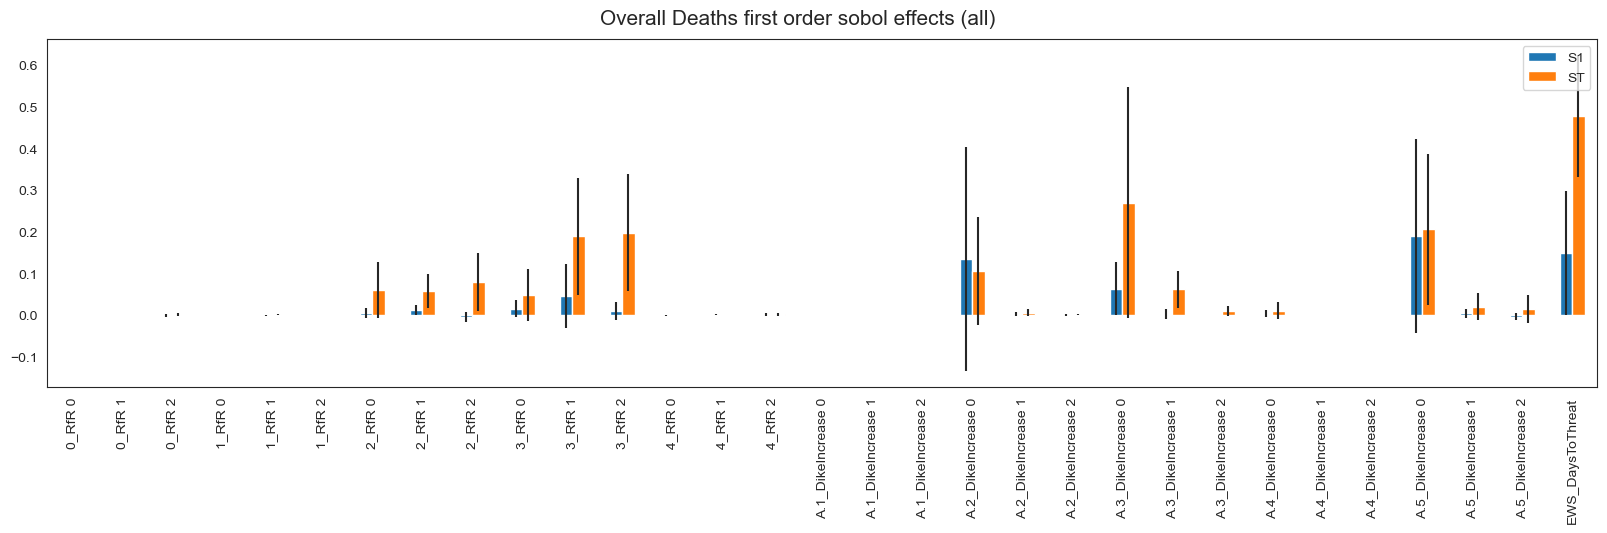

In [11]:
plot_sobol_effects(policy_space_dict,'Overall Deaths', 'first','all')

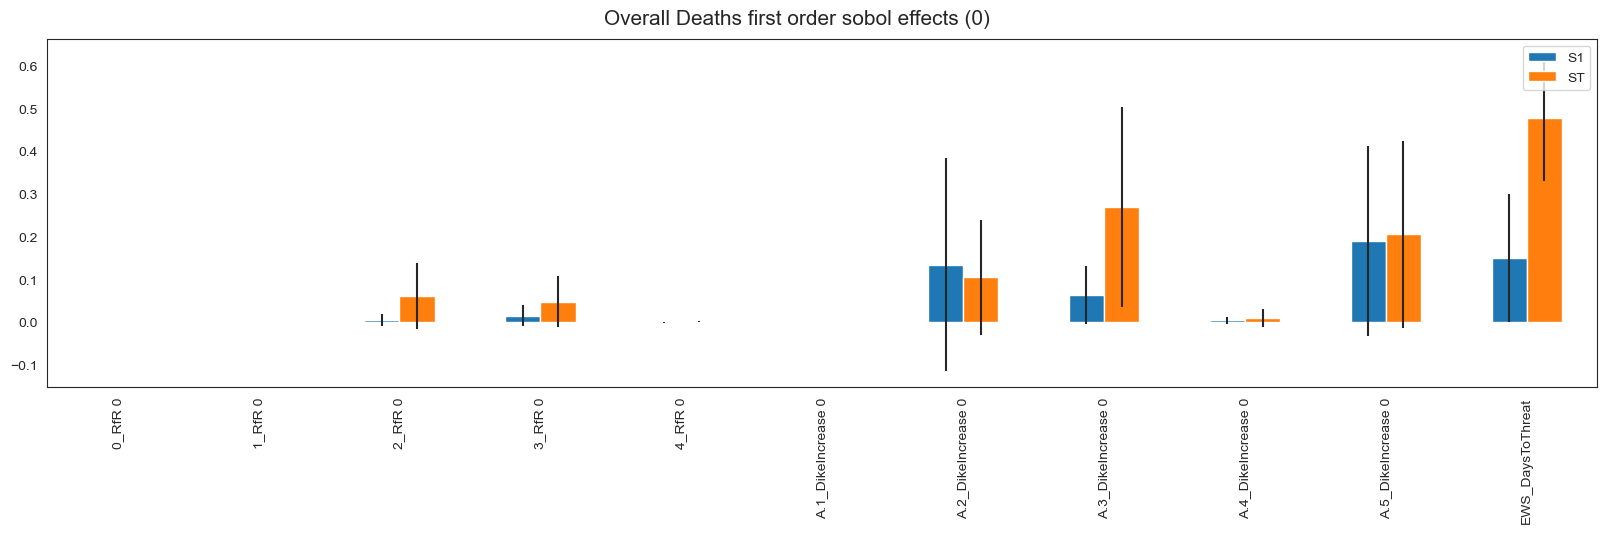

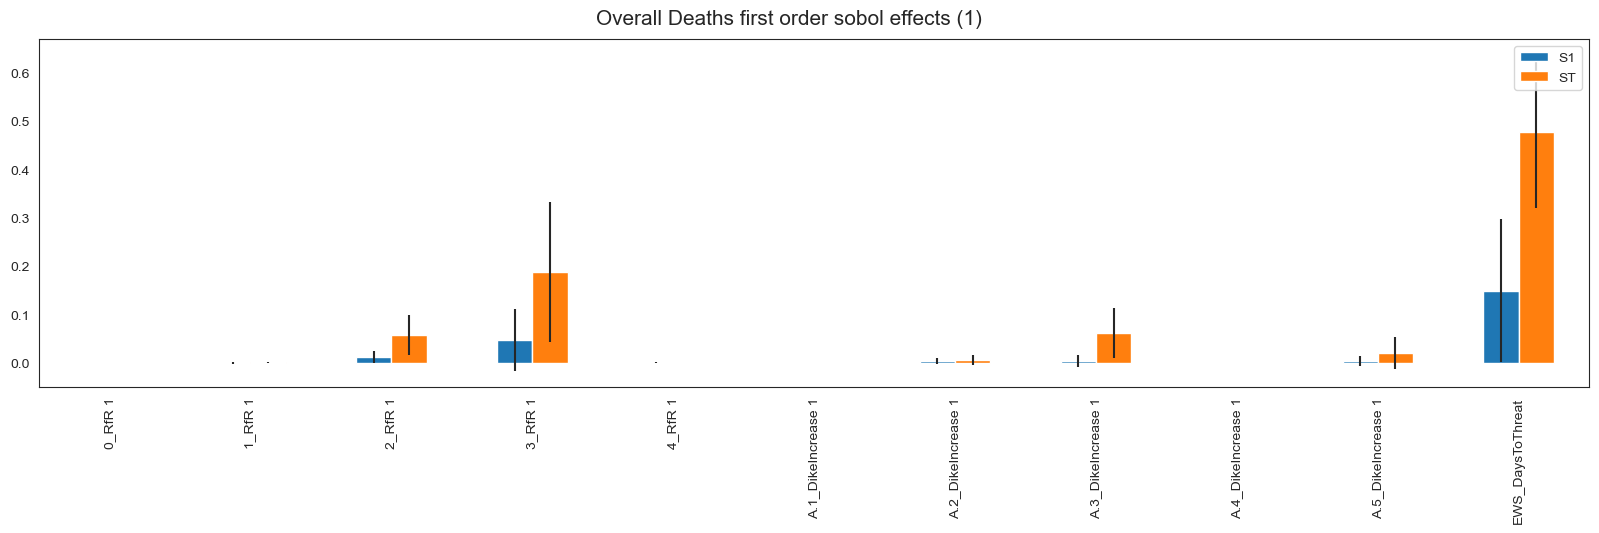

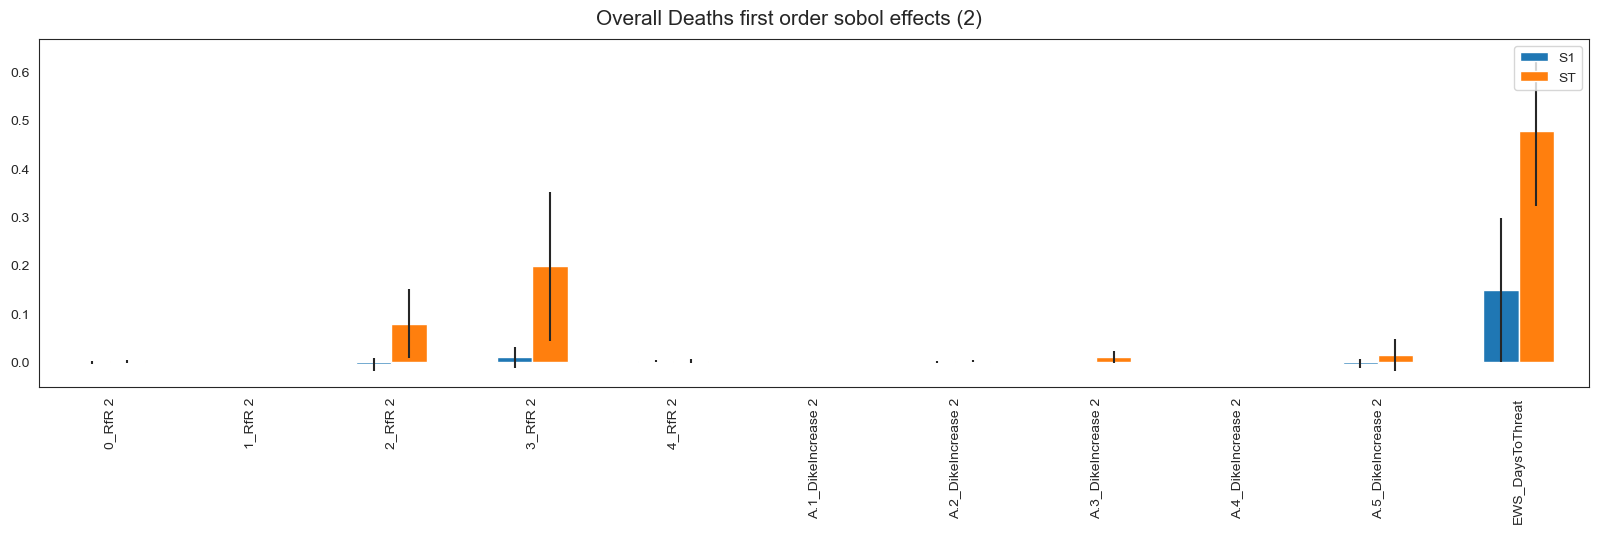

In [12]:
plot_sobol_effects(policy_space_dict,'Overall Deaths', 'first','0')
plot_sobol_effects(policy_space_dict,'Overall Deaths', 'first','1')
plot_sobol_effects(policy_space_dict,'Overall Deaths', 'first','2')

Second order Sobol effects

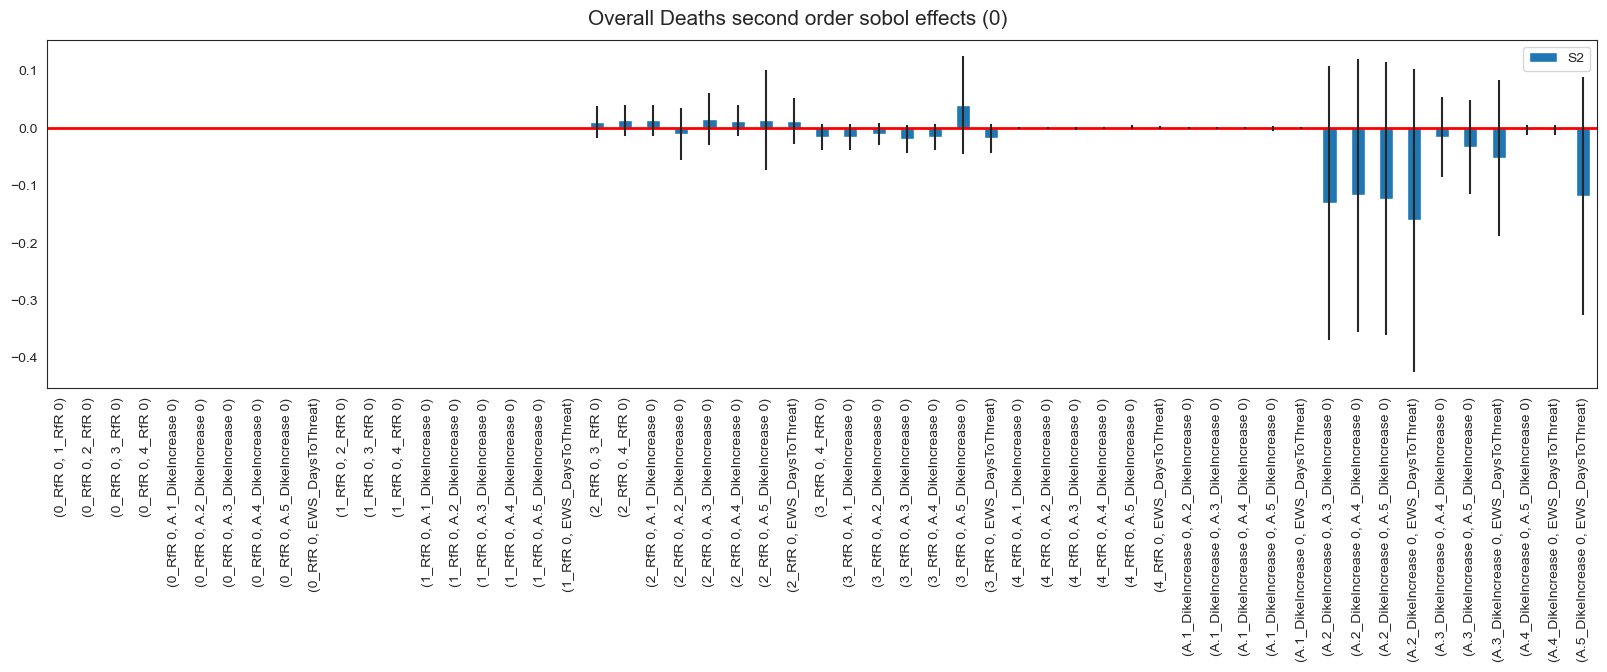

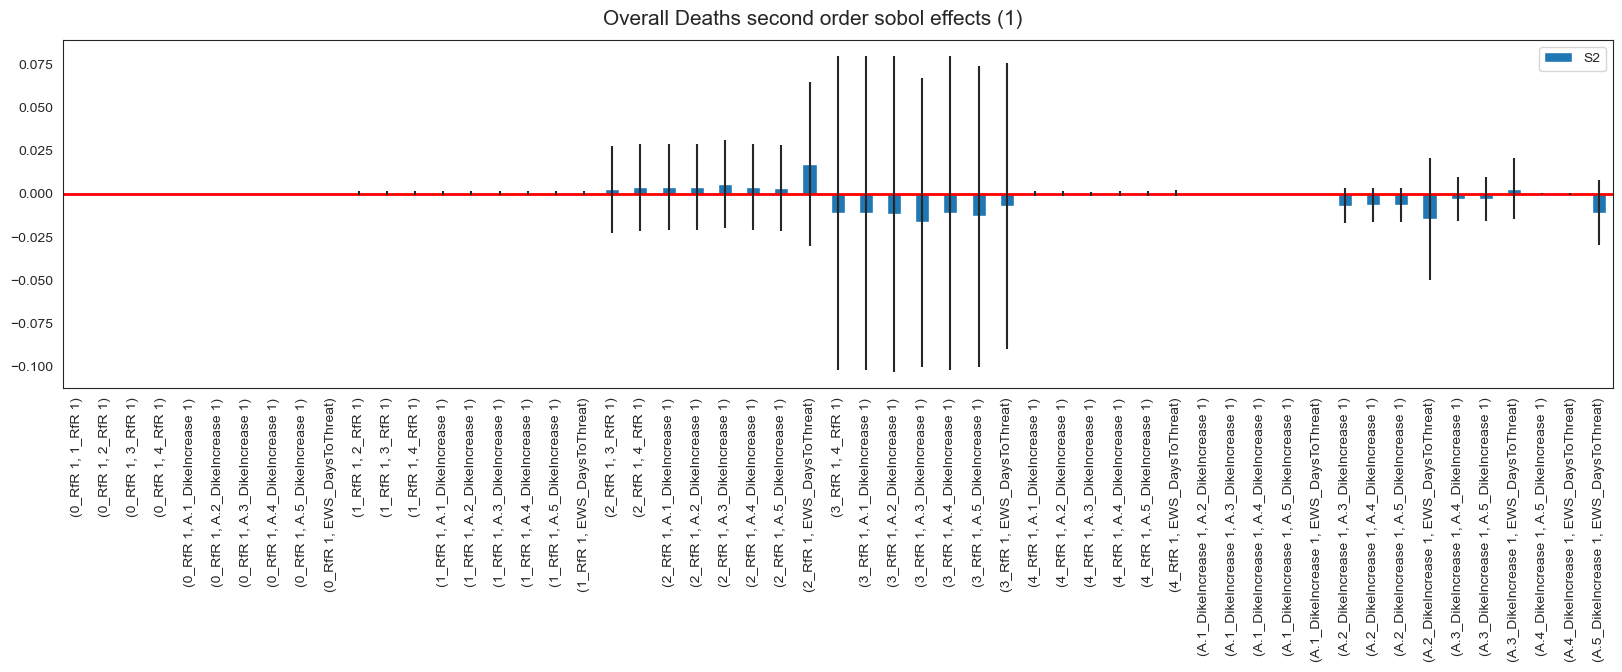

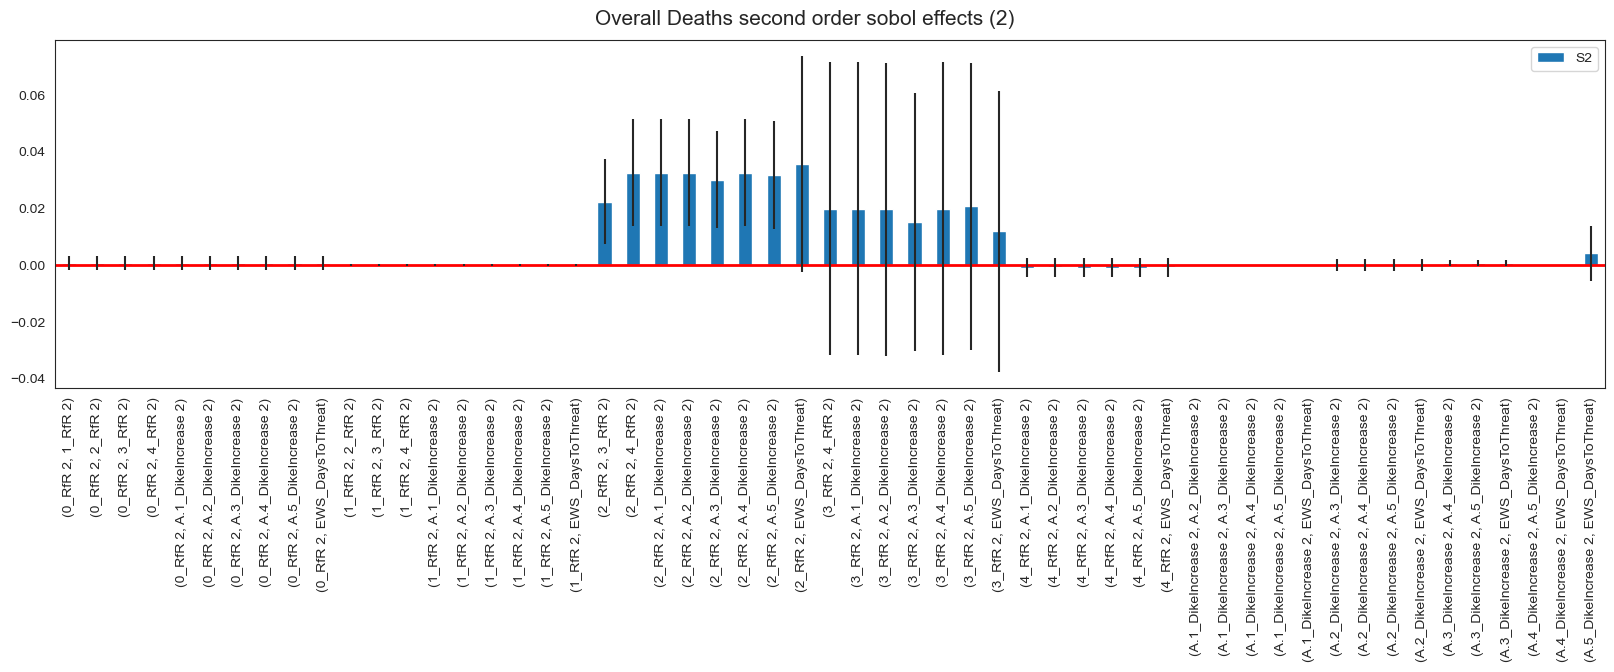

In [13]:
plot_sobol_effects(policy_space_dict,'Overall Deaths', 'second','0')
plot_sobol_effects(policy_space_dict,'Overall Deaths', 'second','1')
plot_sobol_effects(policy_space_dict,'Overall Deaths', 'second','2')

## Overall Damages Analysis 
First order sobol effects

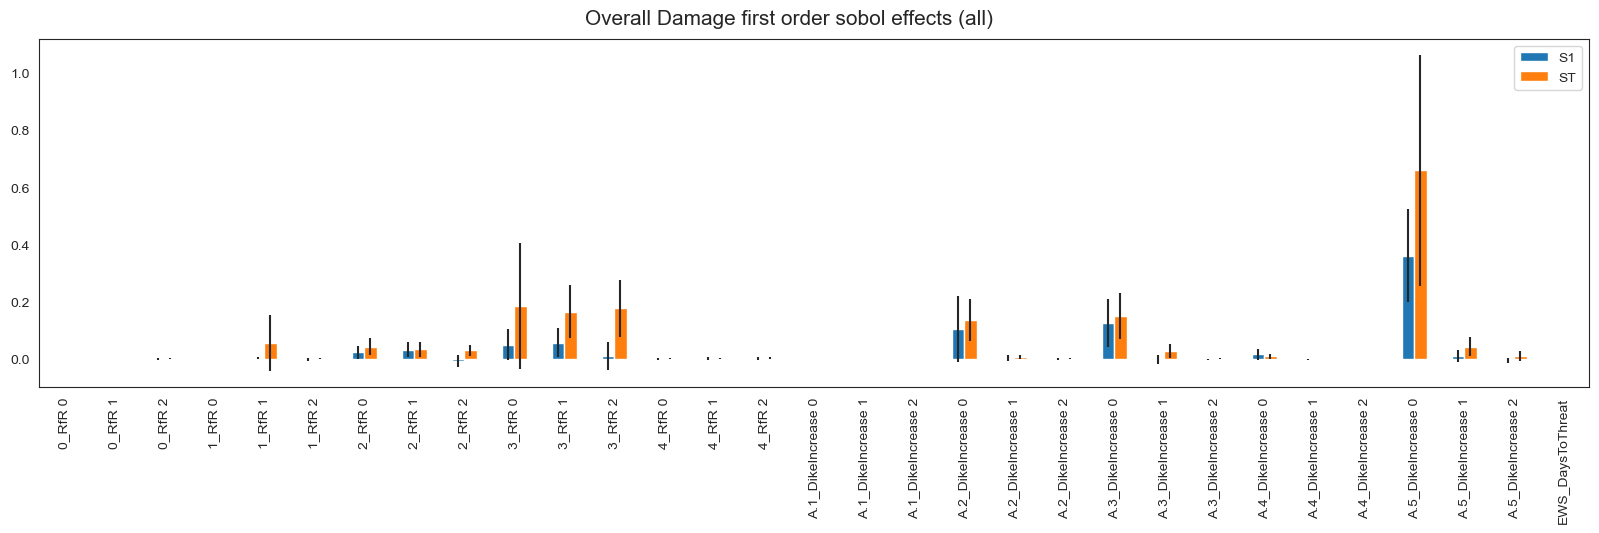

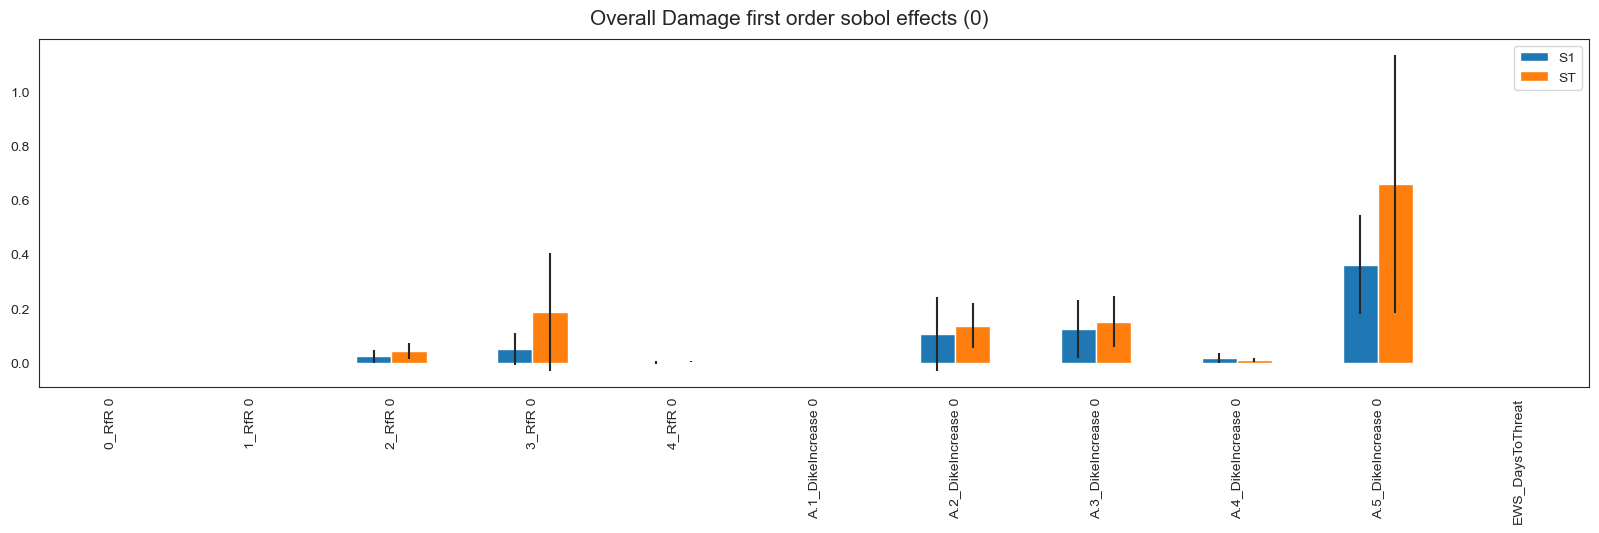

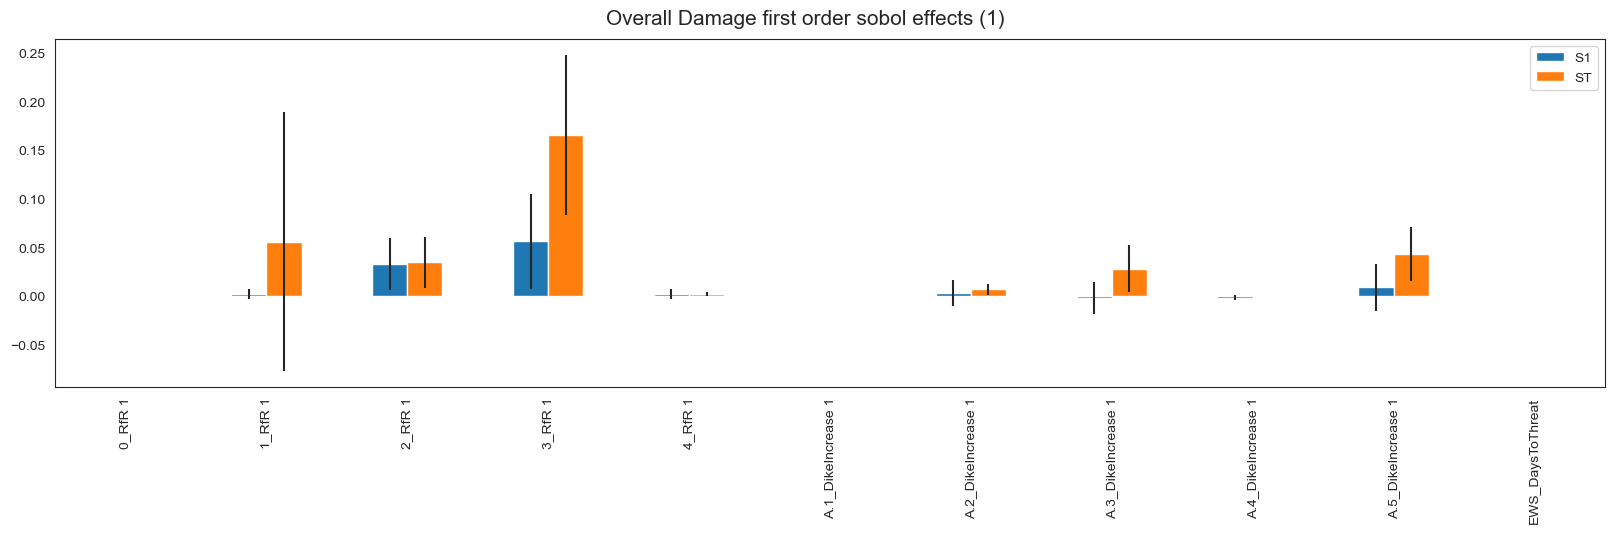

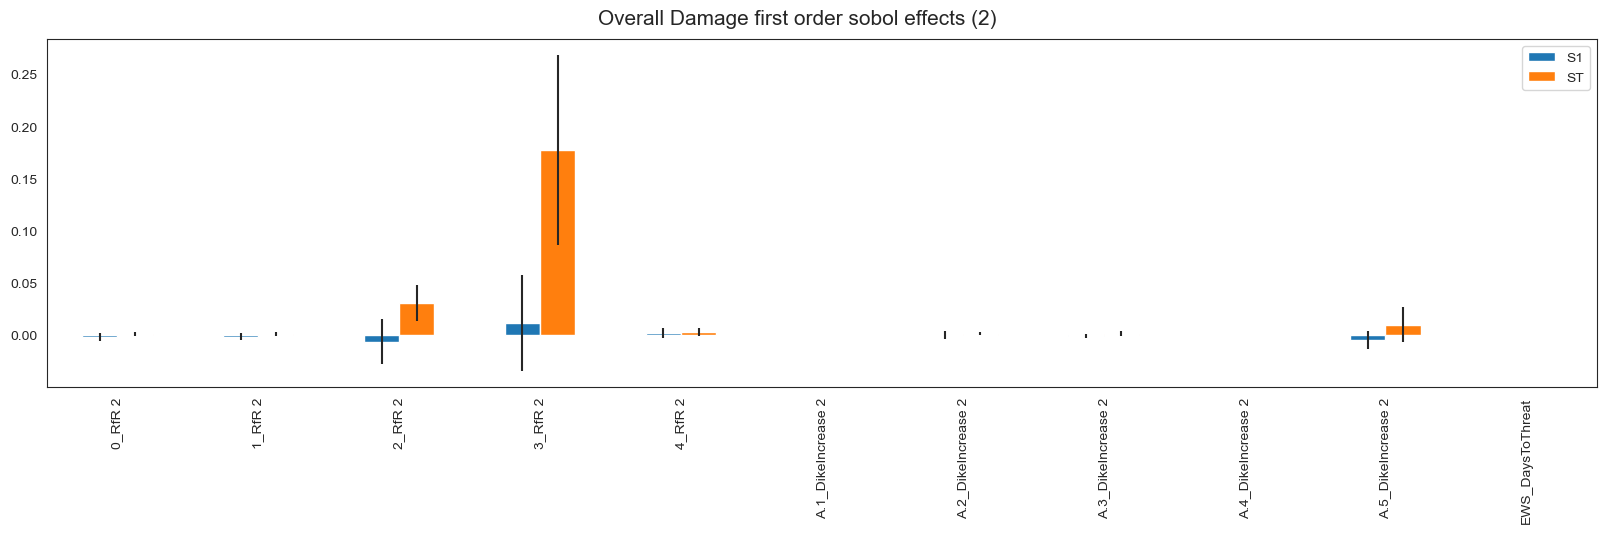

In [14]:
plot_sobol_effects(policy_space_dict,'Overall Damage', 'first','all')
plot_sobol_effects(policy_space_dict,'Overall Damage', 'first','0')
plot_sobol_effects(policy_space_dict,'Overall Damage', 'first','1')
plot_sobol_effects(policy_space_dict,'Overall Damage', 'first','2')

Second order Sobol effects

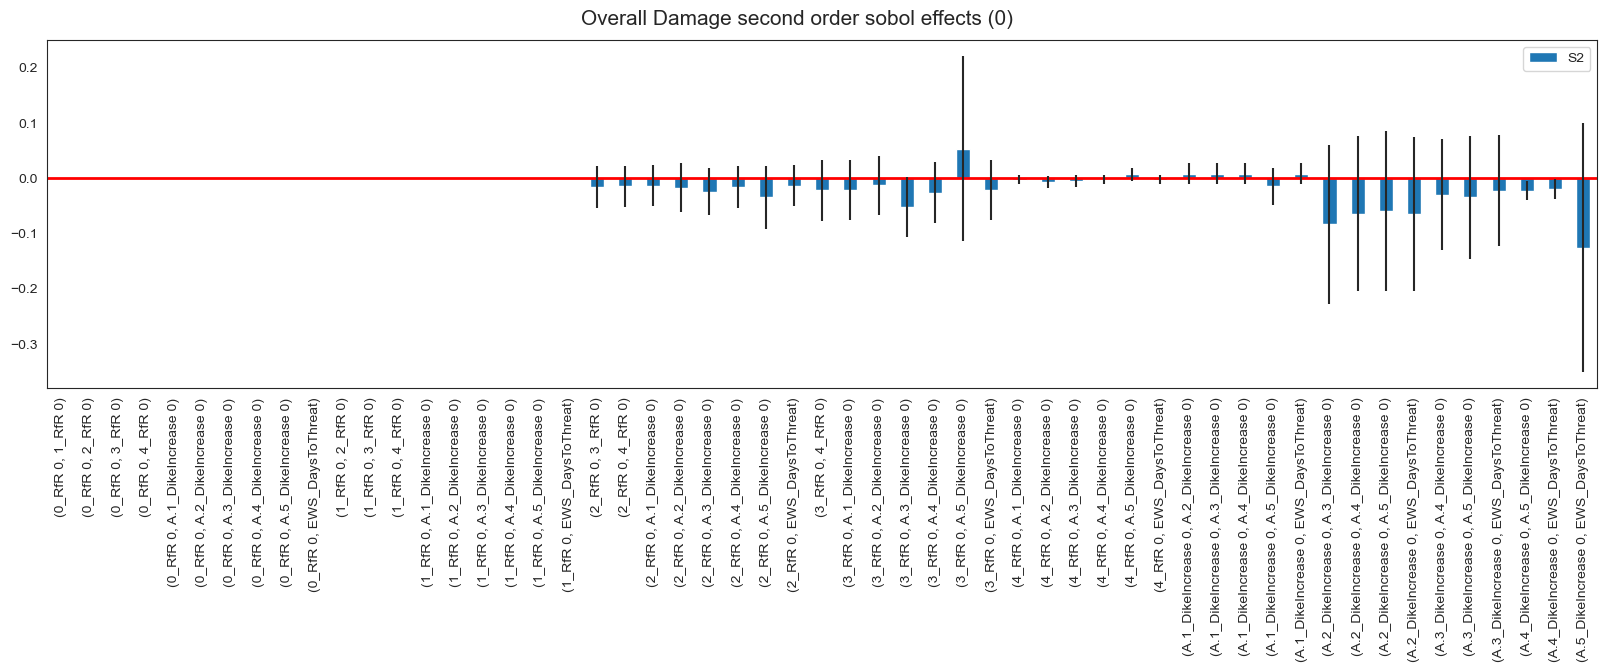

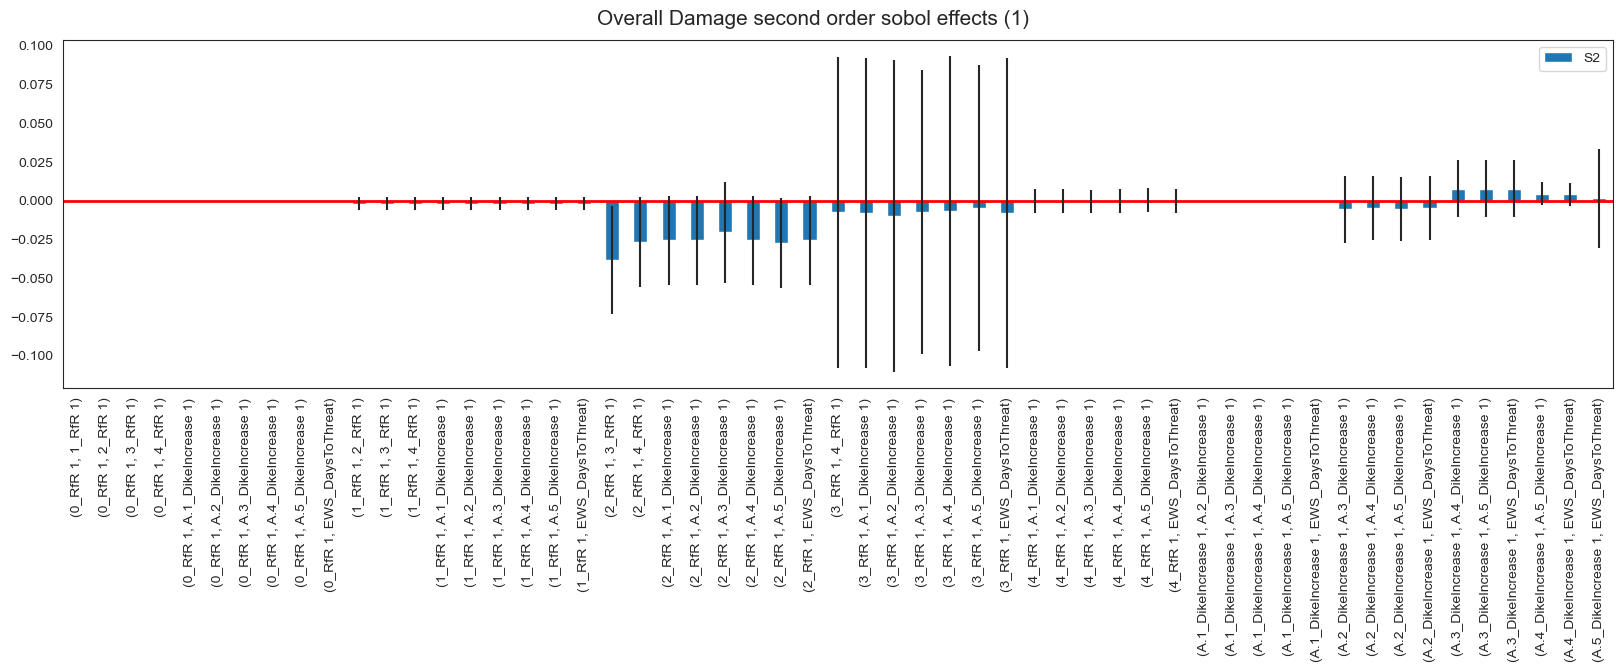

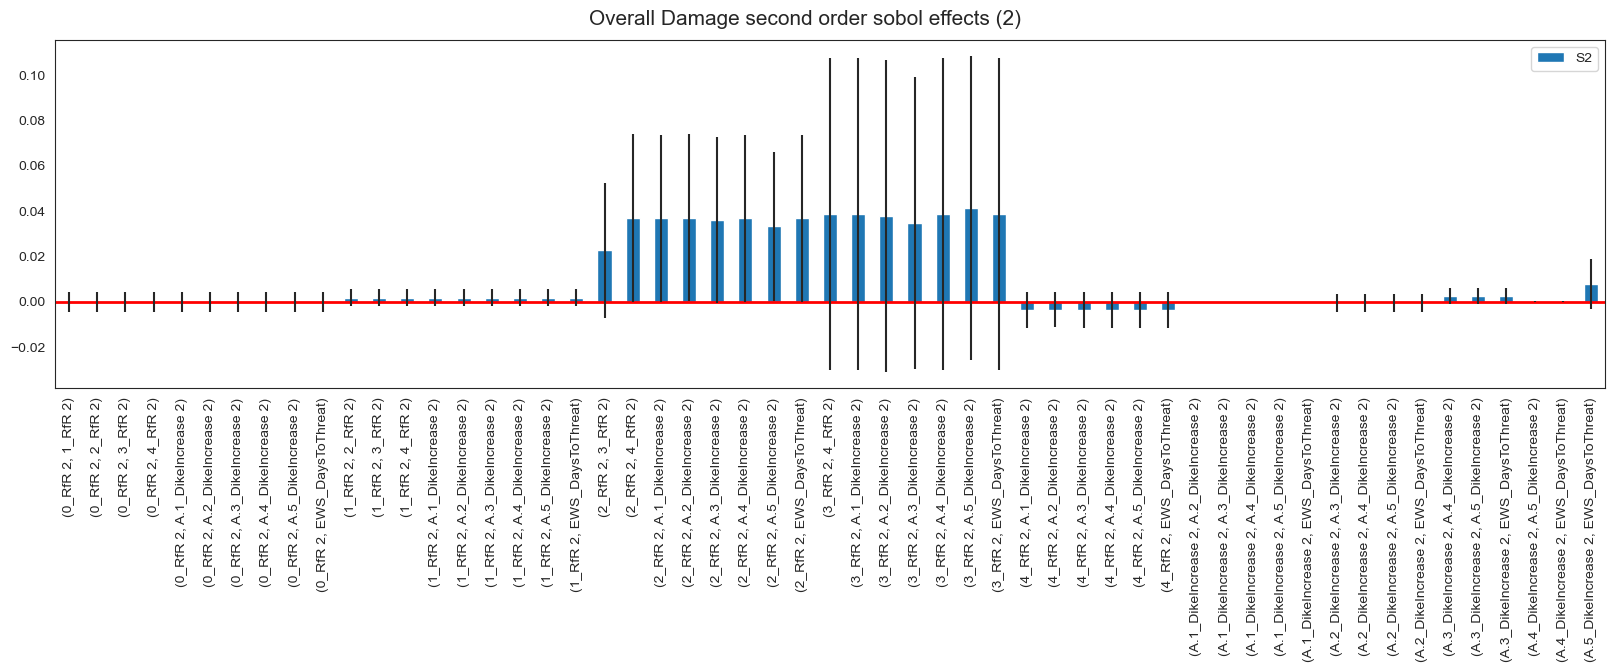

In [15]:
plot_sobol_effects(policy_space_dict,'Overall Damage', 'second','0')
plot_sobol_effects(policy_space_dict,'Overall Damage', 'second','1')
plot_sobol_effects(policy_space_dict,'Overall Damage', 'second','2')

Plot the total second order Sobol effects for overall deaths, damage, dike increase costs and expected evacuation costs

In [16]:
# # Assuming Si_filter_s2 and S2_df are generated as in your code snippet

def sort_second_order_overall_effects(variable):
    problem = get_SALib_problem(levers)
    Si = sobol.analyze(problem, policy_space_dict[variable], print_to_console=False)
    
    Si_filter_s1_st = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter_s1_st, index= problem['names'])
    
    Si_filter_s2 = {k: Si[k] for k in ['S2','S2_conf']}
    S2_df = pd.DataFrame(flatten_dict_arrays(Si_filter_s2), index=list(itertools.product(problem['names'], repeat=2)))

    # Sort S2_df by 'S2' in descending order
    S2_df_sorted = S2_df.sort_values(by='S2', ascending=False)

    # Filter rows where 'S2' > 0
    S2_df_sorted_filtered = S2_df_sorted[abs(S2_df_sorted['S2']) > 0.01]

    # Visualize Sobol indices
    sns.set_style('white')
    fig, ax = plt.subplots(1)

    # Drop NaN values from 'S2' and 'S2_conf' columns
    indices = S2_df_sorted_filtered[["S2"]].dropna()
    err = S2_df_sorted_filtered[['S2_conf']].dropna()

    # Plotting bar chart
    indices.plot.bar(yerr=err.values.T, ax=ax)

    # Adding title and adjusting figure
    fig.suptitle(f'{variable} sorted', fontsize=15, y=0.93)
    fig.set_size_inches(40, 20)  # Adjust figure size as needed
    fig.subplots_adjust(bottom=0.3)

    plt.show()
    return

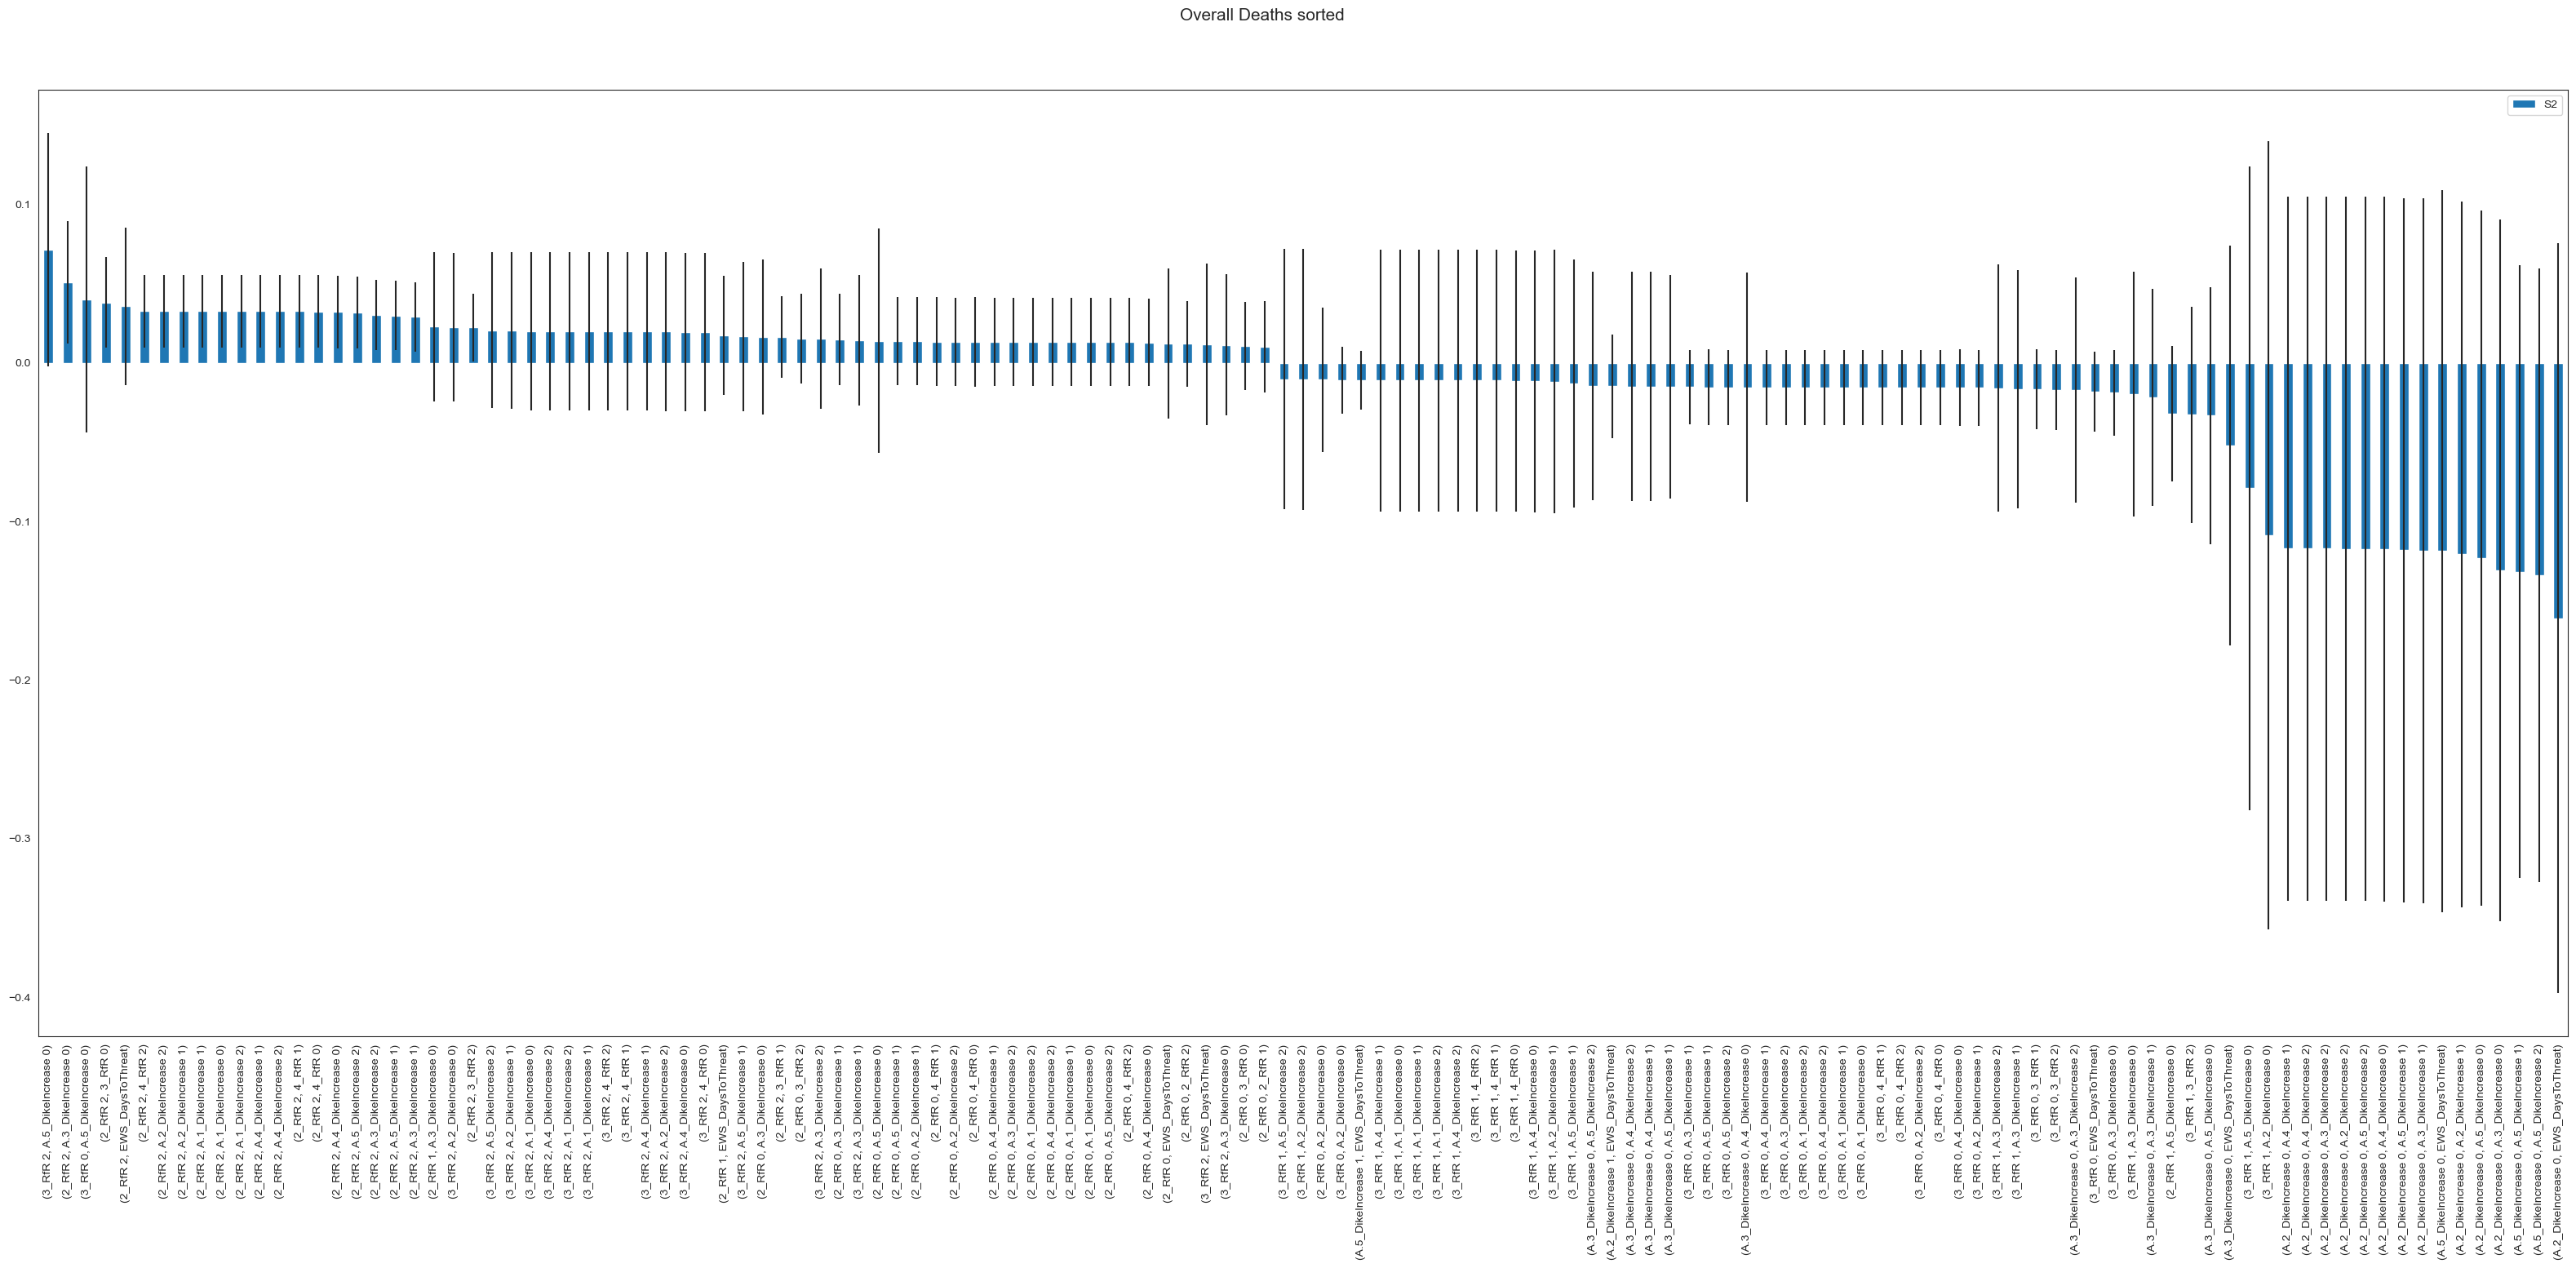

In [17]:
sort_second_order_overall_effects('Overall Deaths')

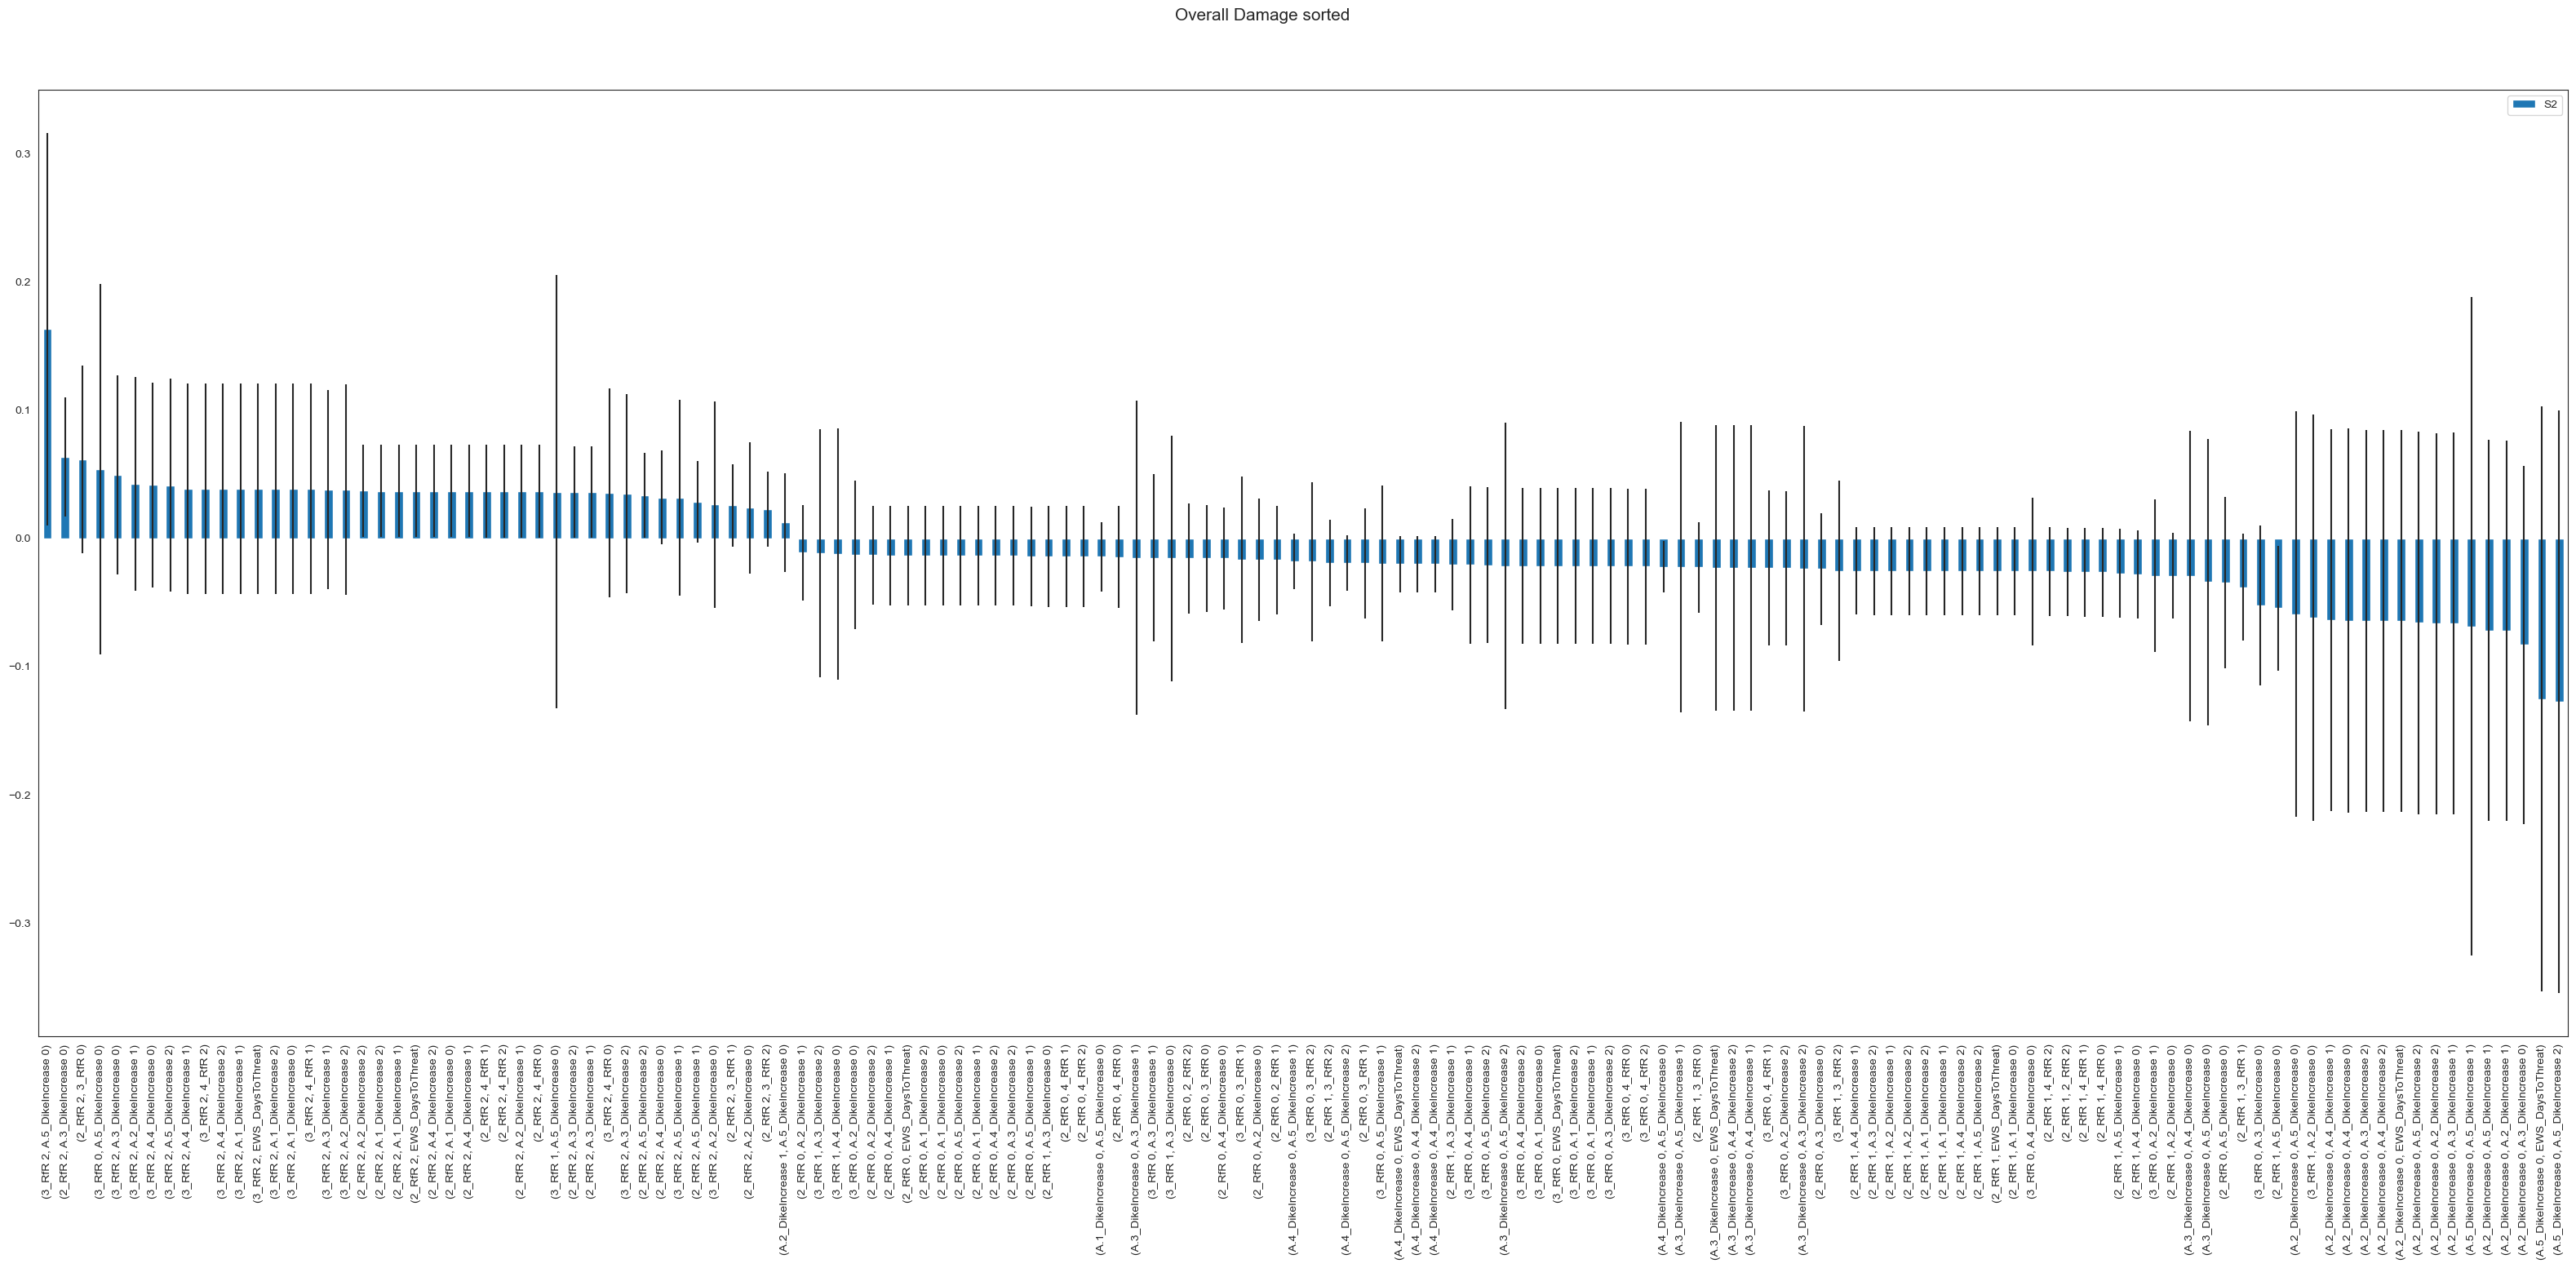

In [18]:
sort_second_order_overall_effects('Overall Damage')

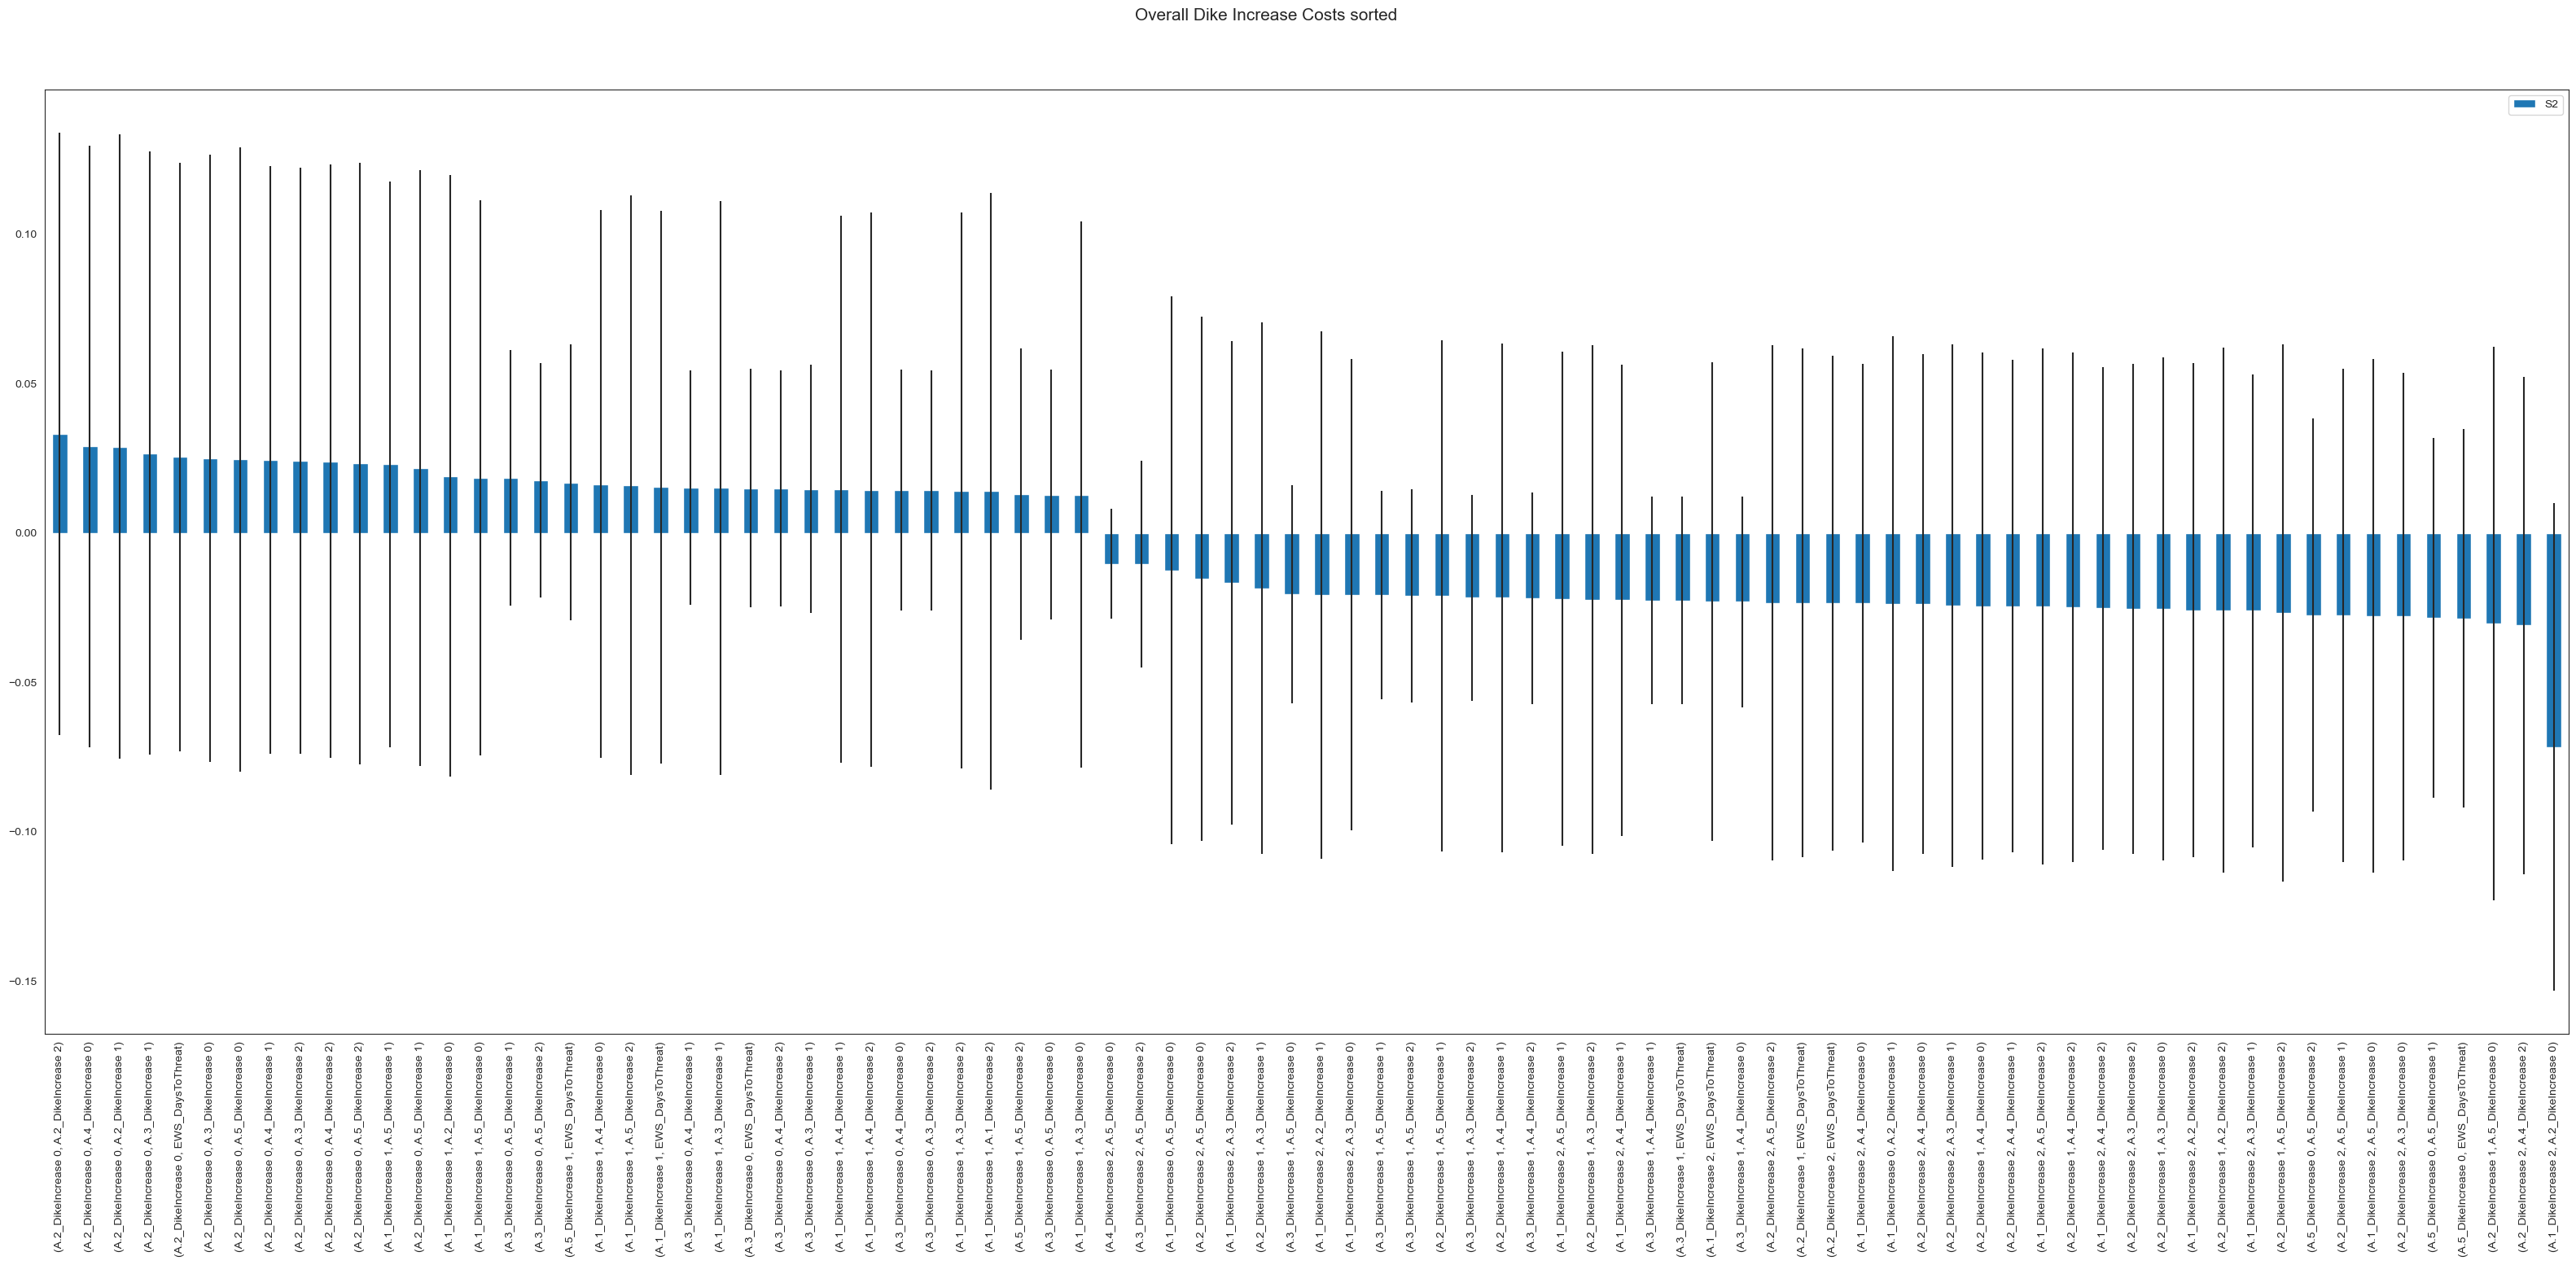

In [19]:
sort_second_order_overall_effects('Overall Dike Increase Costs')

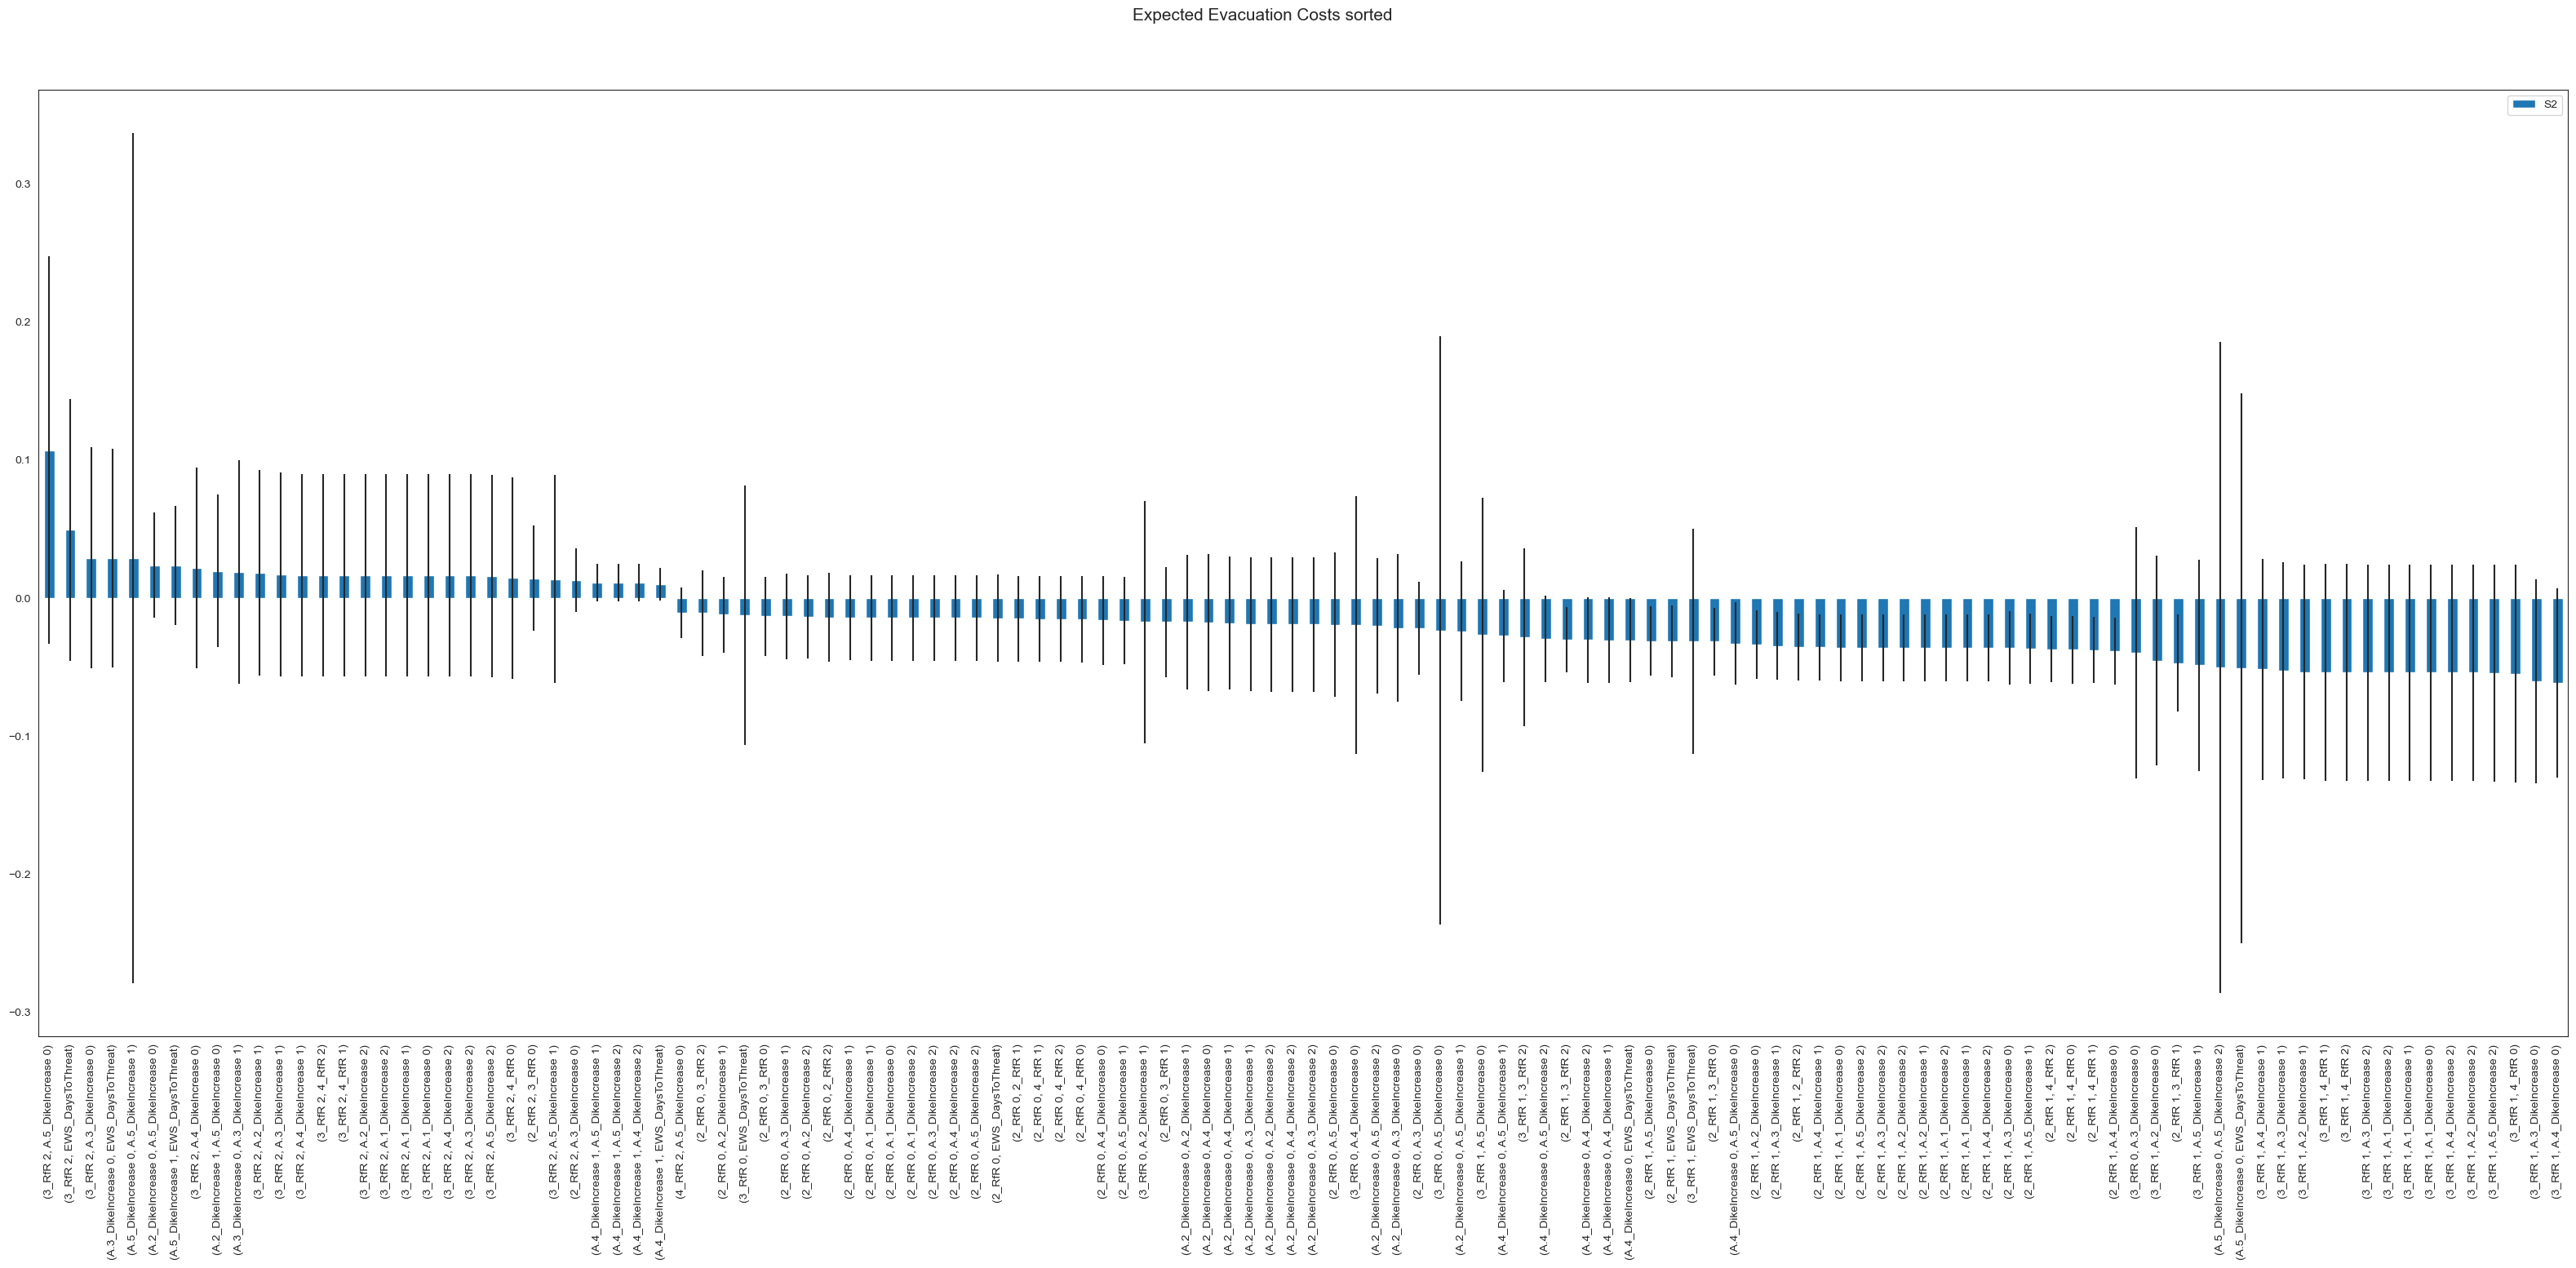

In [20]:
sort_second_order_overall_effects('Expected Evacuation Costs')

## 4. Feauture scoring

It is interesting to see which policy levers impact the outcomes on both an aggregated as a disaggregated level. For this reason the contribution of each lever to these outcomes is depicted in a heatmap produced by feature scoring.

In [21]:
# Create a dataframe only containing the aggregated results added to the outcomes
aggregate_policy_space = policy_space[['Overall Damage', 'Overall Deaths', 'Aggregated Investment','Project and Damage Costs']]
# aggregate_policy_space

C:\Users\mnmar\anacondaGoede\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\mnmar\anacondaGoede\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


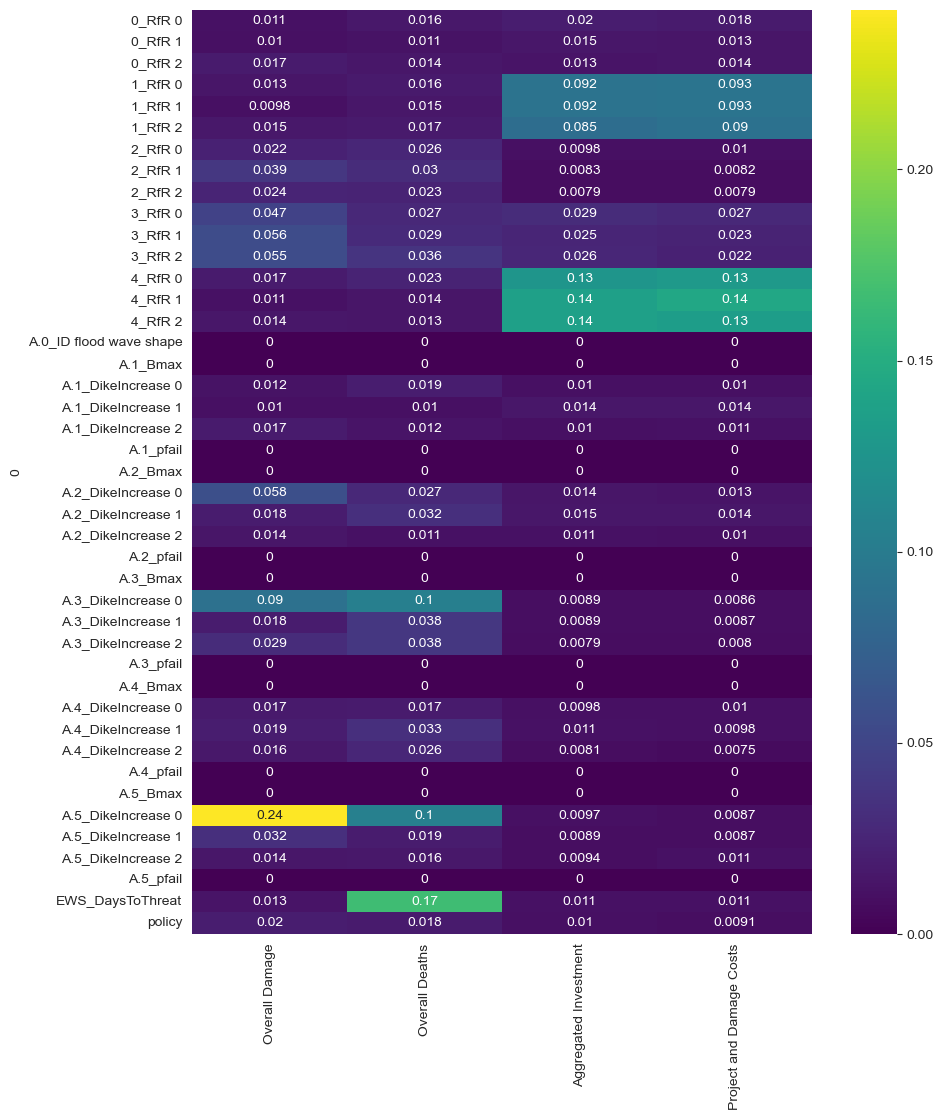

In [22]:
# Aggregated feature scoring
x = pol_experiments_df
y = aggregate_policy_space

fs = feature_scoring.get_feature_scores_all(x, y)

plt.figure(figsize=(10, 12))
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

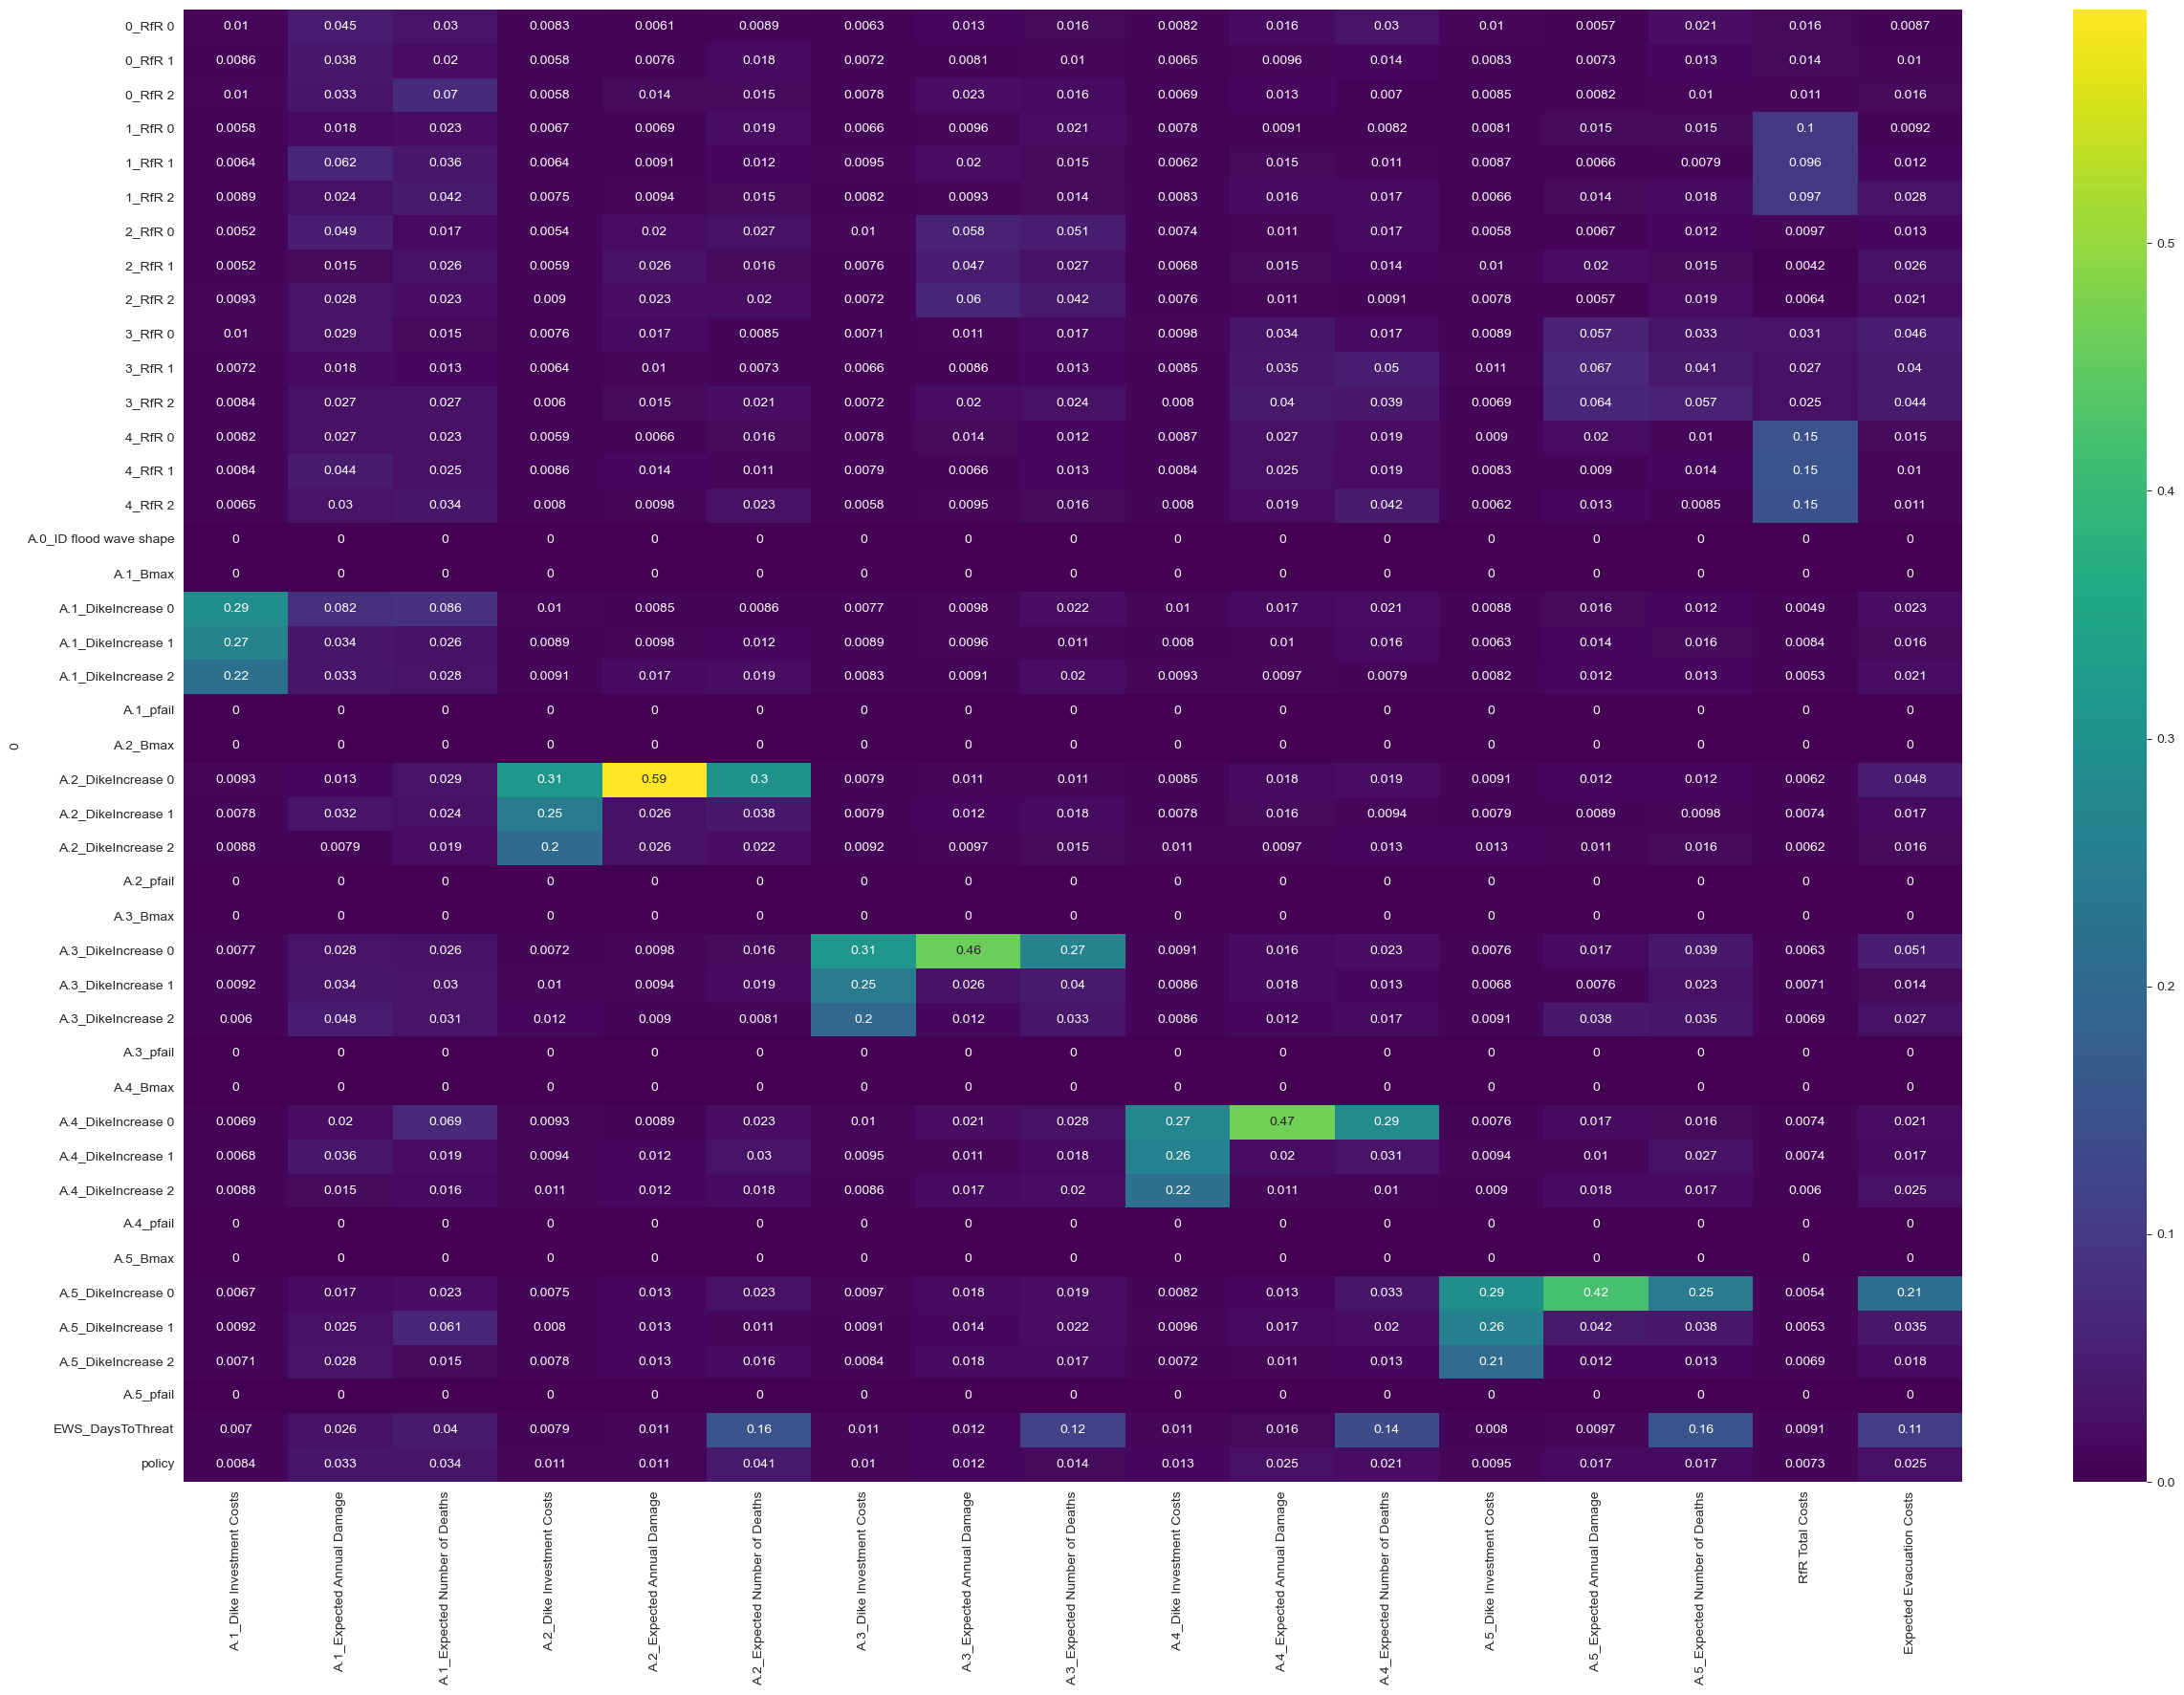

In [23]:
# Disaggregated feature scoring: inspect the results on a local level to predict policy constraints

x = pol_experiments_df
y = policy_outcomes_df

fs = feature_scoring.get_feature_scores_all(x, y)

plt.figure(figsize=(30, 20))
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

<Axes: ylabel='0'>

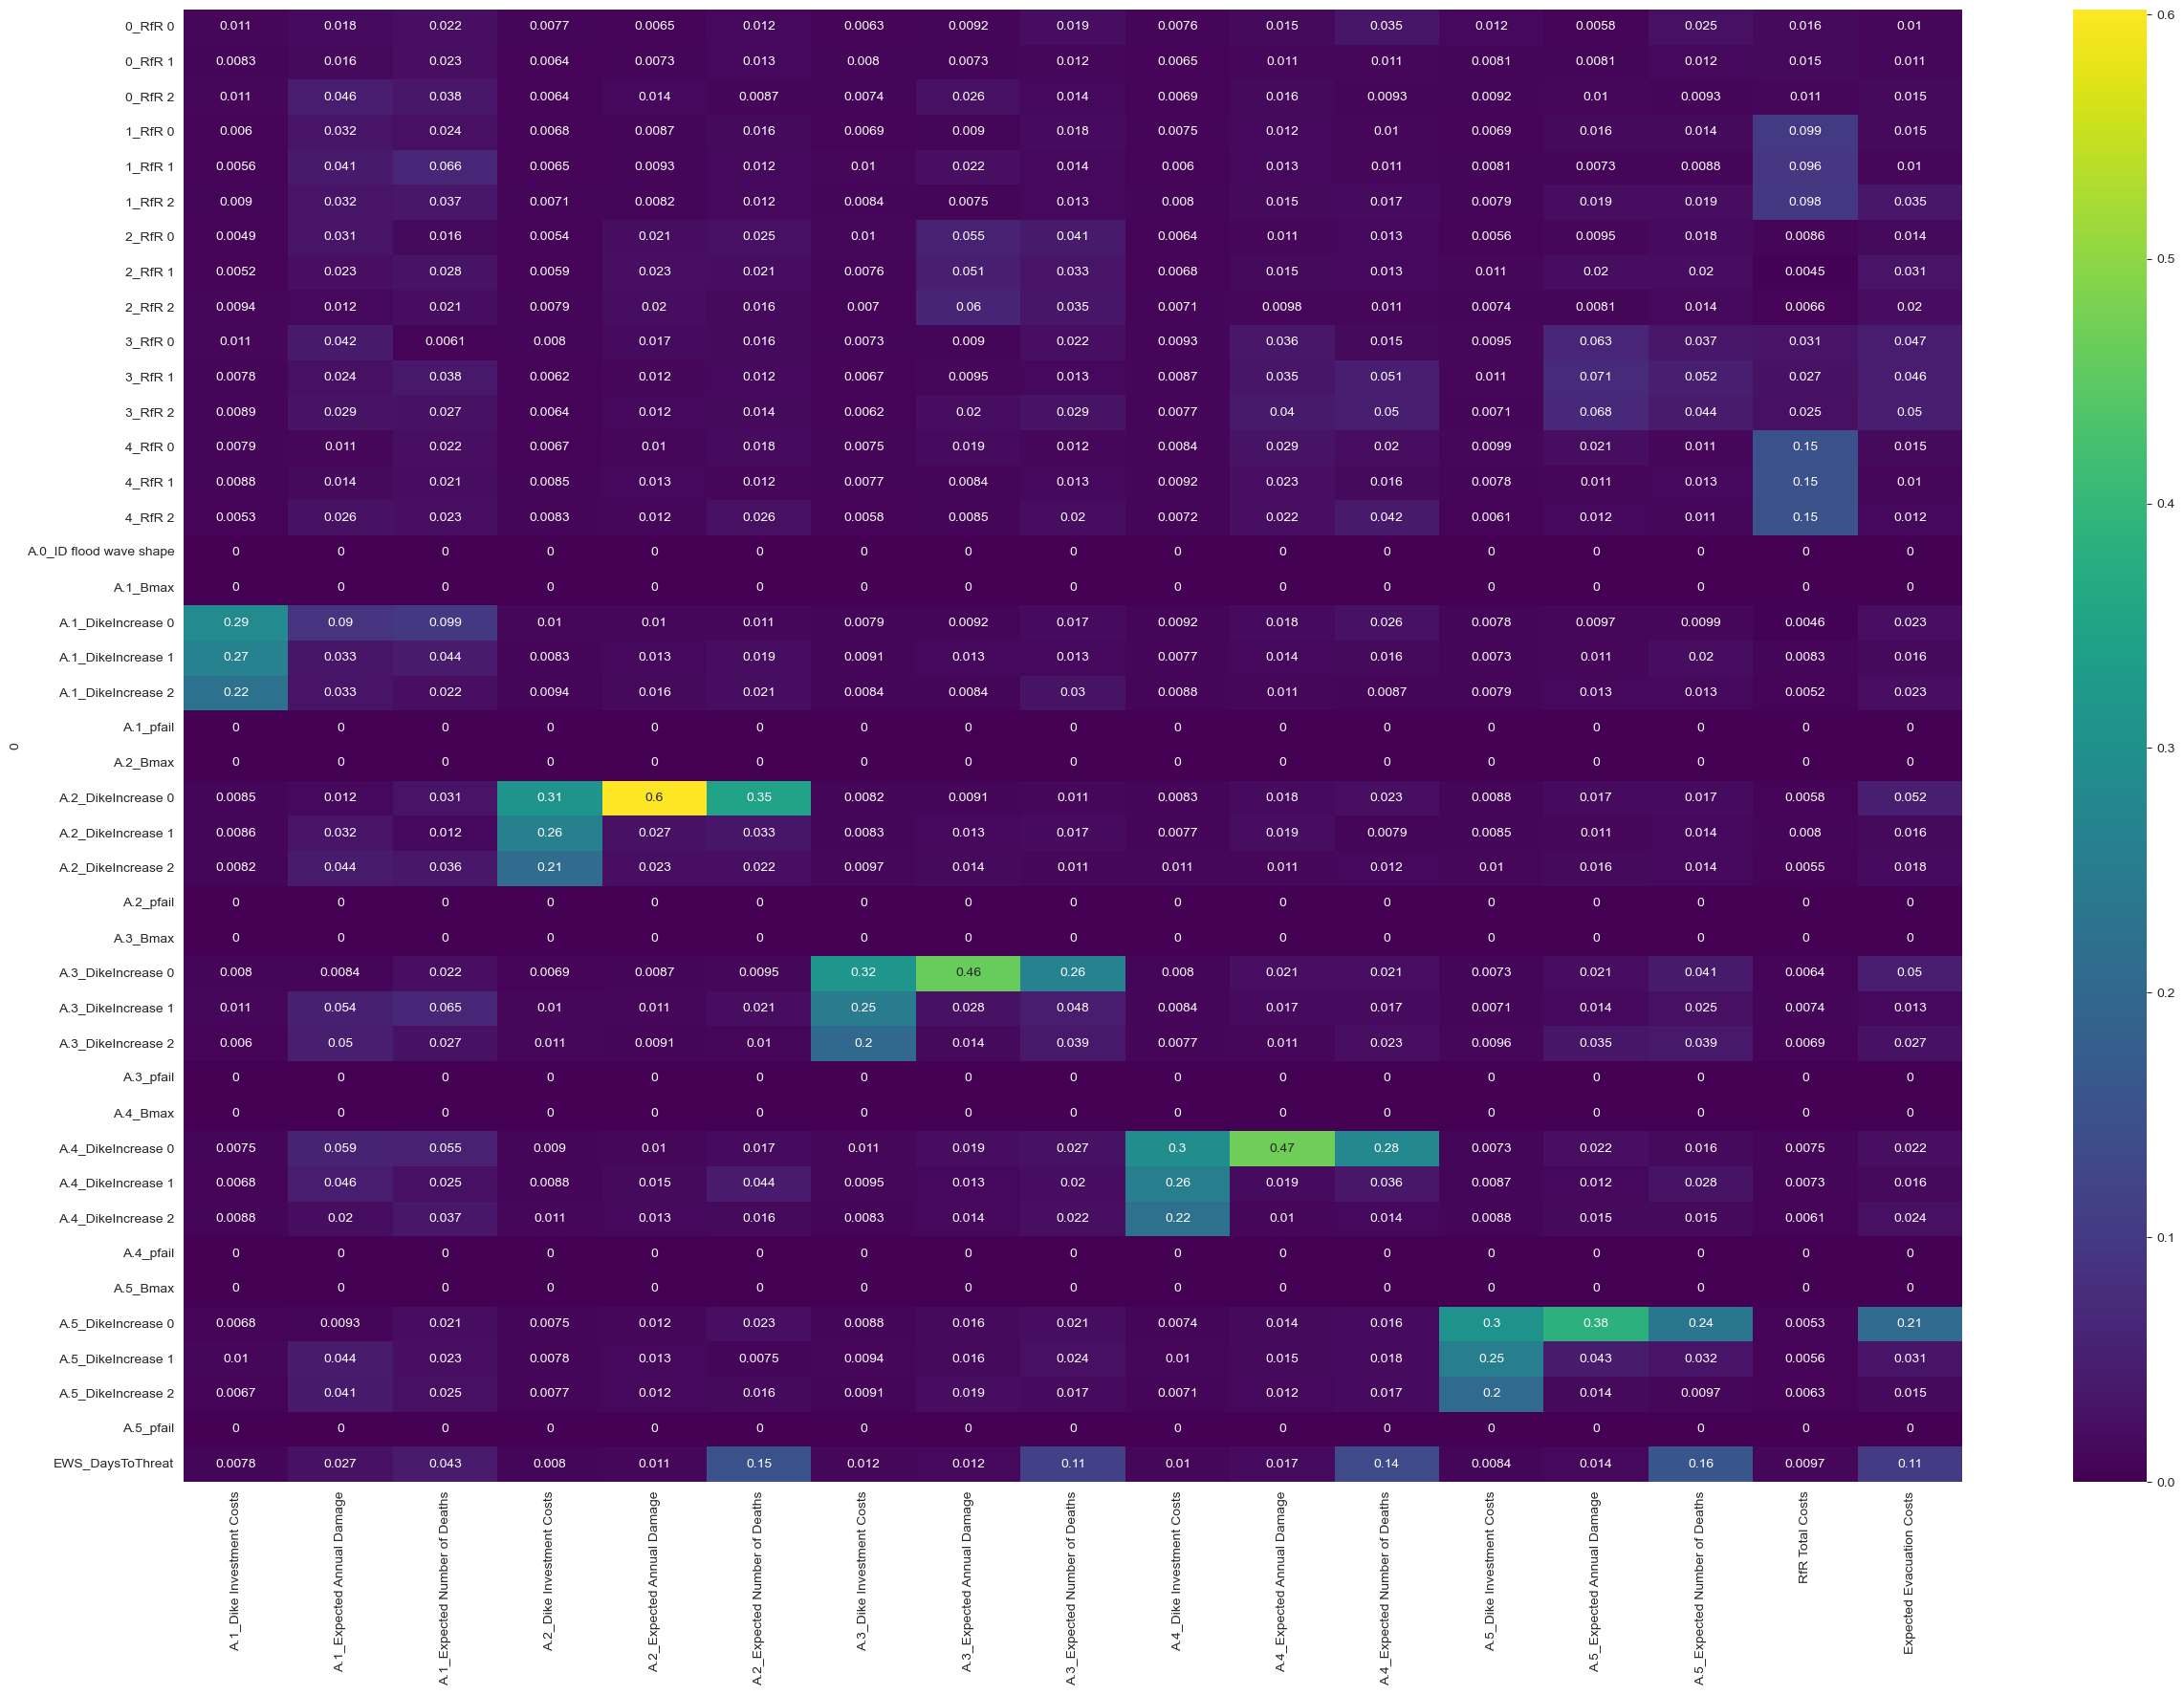

In [24]:
#Drop policy, which can be seen as the lowest row 
cleaned_experiments = pol_experiments.drop(columns=['policy'])
scores = feature_scoring.get_feature_scores_all(cleaned_experiments,policy_outcomes_df)

plt.figure(figsize=(30, 20))
sns.heatmap(scores,cmap='viridis', annot=True)

The resulting seaborn heatmaps allowed us to visualize the feature importances for each policy. 
